# Imports

In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
from scipy.stats.distributions import expon
from scipy.stats import uniform
from sklearn.metrics import ConfusionMatrixDisplay
import os
import glob
import re
import h2o
import tqdm
import pickle
from autoxgb import AutoXGB
from autoxgb.cli.predict import PredictAutoXGBCommand

%matplotlib notebook
rng = np.random.RandomState(42)

In [2]:
from autoxgb import AutoXGB

# Functions

In [3]:
def look_at_anti_dist(all_ASR, col_name, col_order=None):
    col_dist = all_ASR.groupby(by='antibiotic_name')[col_name].apply(lambda x: x.value_counts()).reset_index()
    col_dist.columns = ['antibiotic_name', col_name, 'count']
    order = col_dist.groupby(by='antibiotic_name')['count'].apply(sum).sort_values().index
    col_dist = pd.pivot_table(col_dist, values='count', index=['antibiotic_name'],
                    columns=[col_name], aggfunc=np.sum).fillna(0)
    if col_order is not None:
        col_dist = col_dist[col_order]
    ax = col_dist.loc[order].plot.barh(stacked=True, rot=0, figsize=(20,15))
    plt.title('Distribution of ' + col_name+' for each anti-biotics')
    plt.ylabel('antibiotics')
    plt.xlabel('# of measurements')
    plt.legend(loc='lower right')

In [4]:
def print_anti_measure(all_ASR, anti_index):
    anti = all_ASR['antibiotic_name'].value_counts().index[anti_index]
    anti_MIC = all_ASR[all_ASR['antibiotic_name'] == anti]
    anti_MIC['measurement'] = anti_MIC['measurement'].apply(np.log2)
    low = anti_MIC['measurement'].min().round()
    high = anti_MIC['measurement'].max().round()
    hist_range = np.arange(low-0.5, high+1, 1)
    bins_count = pd.DataFrame(anti_MIC.groupby(by='measurement_sign')['measurement'].apply(lambda x: np.histogram(x, bins=hist_range)[0]))
    bins_count = bins_count.merge(pd.DataFrame({'fill': [np.zeros(len(hist_range)-1)]}, index=['=', '<=', '>=', '<', '>']), left_index=True, right_index=True, how='right')
    bins_count['measurement'].fillna(bins_count['fill'], inplace=True)
    pd.DataFrame(bins_count['measurement'].tolist(), index= bins_count.index, columns=hist_range[:-1]+0.5).T.plot.bar(stacked=True)
    plt.title(anti)
    plt.xlabel('log2(mg//L)')
    plt.ylabel('#')


In [5]:
def get_filtered_data(
    data = 'tot_filtered_data.csv', 
    features = 'final_features',
    ASR_data = 'filtered_ASR_data.csv', 
    species_sep = True, 
    species_filter_index=0, 
    naive=True, 
    test_range=False, 
    antibiotic_index=0,
    task='regression', 
    strip_range_train=False,
    distance_range_train=False,
    range_moved=5,
):
    data = pd.read_csv('../resources/'+data)
    with open("../resources/"+ features, "rb") as fp:
        features = pickle.load(fp)
    ASR_data = pd.read_csv('../resources/'+ASR_data)
    
    
    
    species2merge = data[['biosample_id', 'species_fam']]
    filtered_ASR = ASR_data.drop('species_fam', axis=1).merge(species2merge, on='biosample_id')
    filtered_ASR.set_index('biosample_id', inplace=True)
    filtered_ASR = filtered_ASR[filtered_ASR['units']=='mg/L']
    filtered_ASR = filtered_ASR[filtered_ASR['ast_standard']=='CLSI']
    filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='senterica']
    filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='spneumoniae']
    data.set_index('biosample_id', inplace=True)
    data.drop(['Unnamed: 0', 'species_fam', 'run_id'], axis=1, inplace=True)
            
    if species_sep:
        species = filtered_ASR['species_fam'].value_counts().reset_index()['index'].iloc[species_filter_index]
        filtered_ASR = filtered_ASR[filtered_ASR['species_fam'] == species]
    else:
        species = None
    
    if test_range:
        test_ASR = filtered_ASR[filtered_ASR['measurement_sign']!='=']    
        
    if naive:
        filtered_ASR = filtered_ASR[filtered_ASR['measurement_sign']=='=']
    
    anti_list = filtered_ASR['antibiotic_name'].value_counts().index.values
    label = anti_list[antibiotic_index]
    
    y = data.loc[filtered_ASR[filtered_ASR['antibiotic_name'] == label].index][label]
    
    if naive:
        if task == 'regression':
            y = y.apply(lambda x: float(x.split(' ')[1]))
        elif task == 'classification':
            y = y.apply(lambda x: str(x.split(' ')[1]))
            
    else:
        if task == 'classification':
            y=y
        elif task == 'regression':
            if strip_range_train:
                y = y.apply(lambda x: float(x.split(' ')[1]))
            elif distance_range_train:
                signs = y.apply(lambda x: str(x.split(' ')[0]))
                y = y.apply(lambda x: float(x.split(' ')[1]))
                
            else:
                print('regression not in the naive approach is not implemented yet.') 
        
            
    
    if test_range:
        range_test_values = data.loc[test_ASR[test_ASR['antibiotic_name'] == label].index][label]
        range_labels = pd.DataFrame({
            'values':[],
            'direction': [],
        })
        range_labels['values'] = range_test_values.apply(lambda x: float(x.split(' ')[1]))
        range_labels['direction'] = range_test_values.apply(lambda x: x.split(' ')[0].replace('=', ''))
    else:
        range_labels = None
        X_range = None
        
    
    X = data.loc[filtered_ASR[filtered_ASR['antibiotic_name'] == label].index][features]
    X.dropna(axis=1, how='all', inplace=True)
    X.fillna(0, inplace=True)
    
    if test_range:
        train_features = X.columns.values
        X_range = data.loc[test_ASR[test_ASR['antibiotic_name'] == label].index][train_features]
        X_range.fillna(0, inplace=True)
    
    return X, y, X_range, range_labels, list(train_features), label, species

# Load data

## DataSet

In [6]:
data = pd.read_csv('../resources/tot_filtered_data.csv')
with open("../resources/final_labels", "rb") as fp:
    labels = pickle.load(fp)
with open("../resources/final_features", "rb") as fp:
    features = pickle.load(fp)
    

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,5,6,7,8,10,12,15,18,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,1156,1157,1158,1159,1160,1161,1162,1163,1164) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Meta Data

In [33]:
ASR_data = pd.read_csv('../resources/filtered_ASR_data.csv')
species2merge = data[['unique_id', 'species_fam']]
filtered_ASR = ASR_data.drop('species_fam', axis=1).merge(species2merge, on='unique_id')

# Exploration

<IPython.core.display.Javascript object>


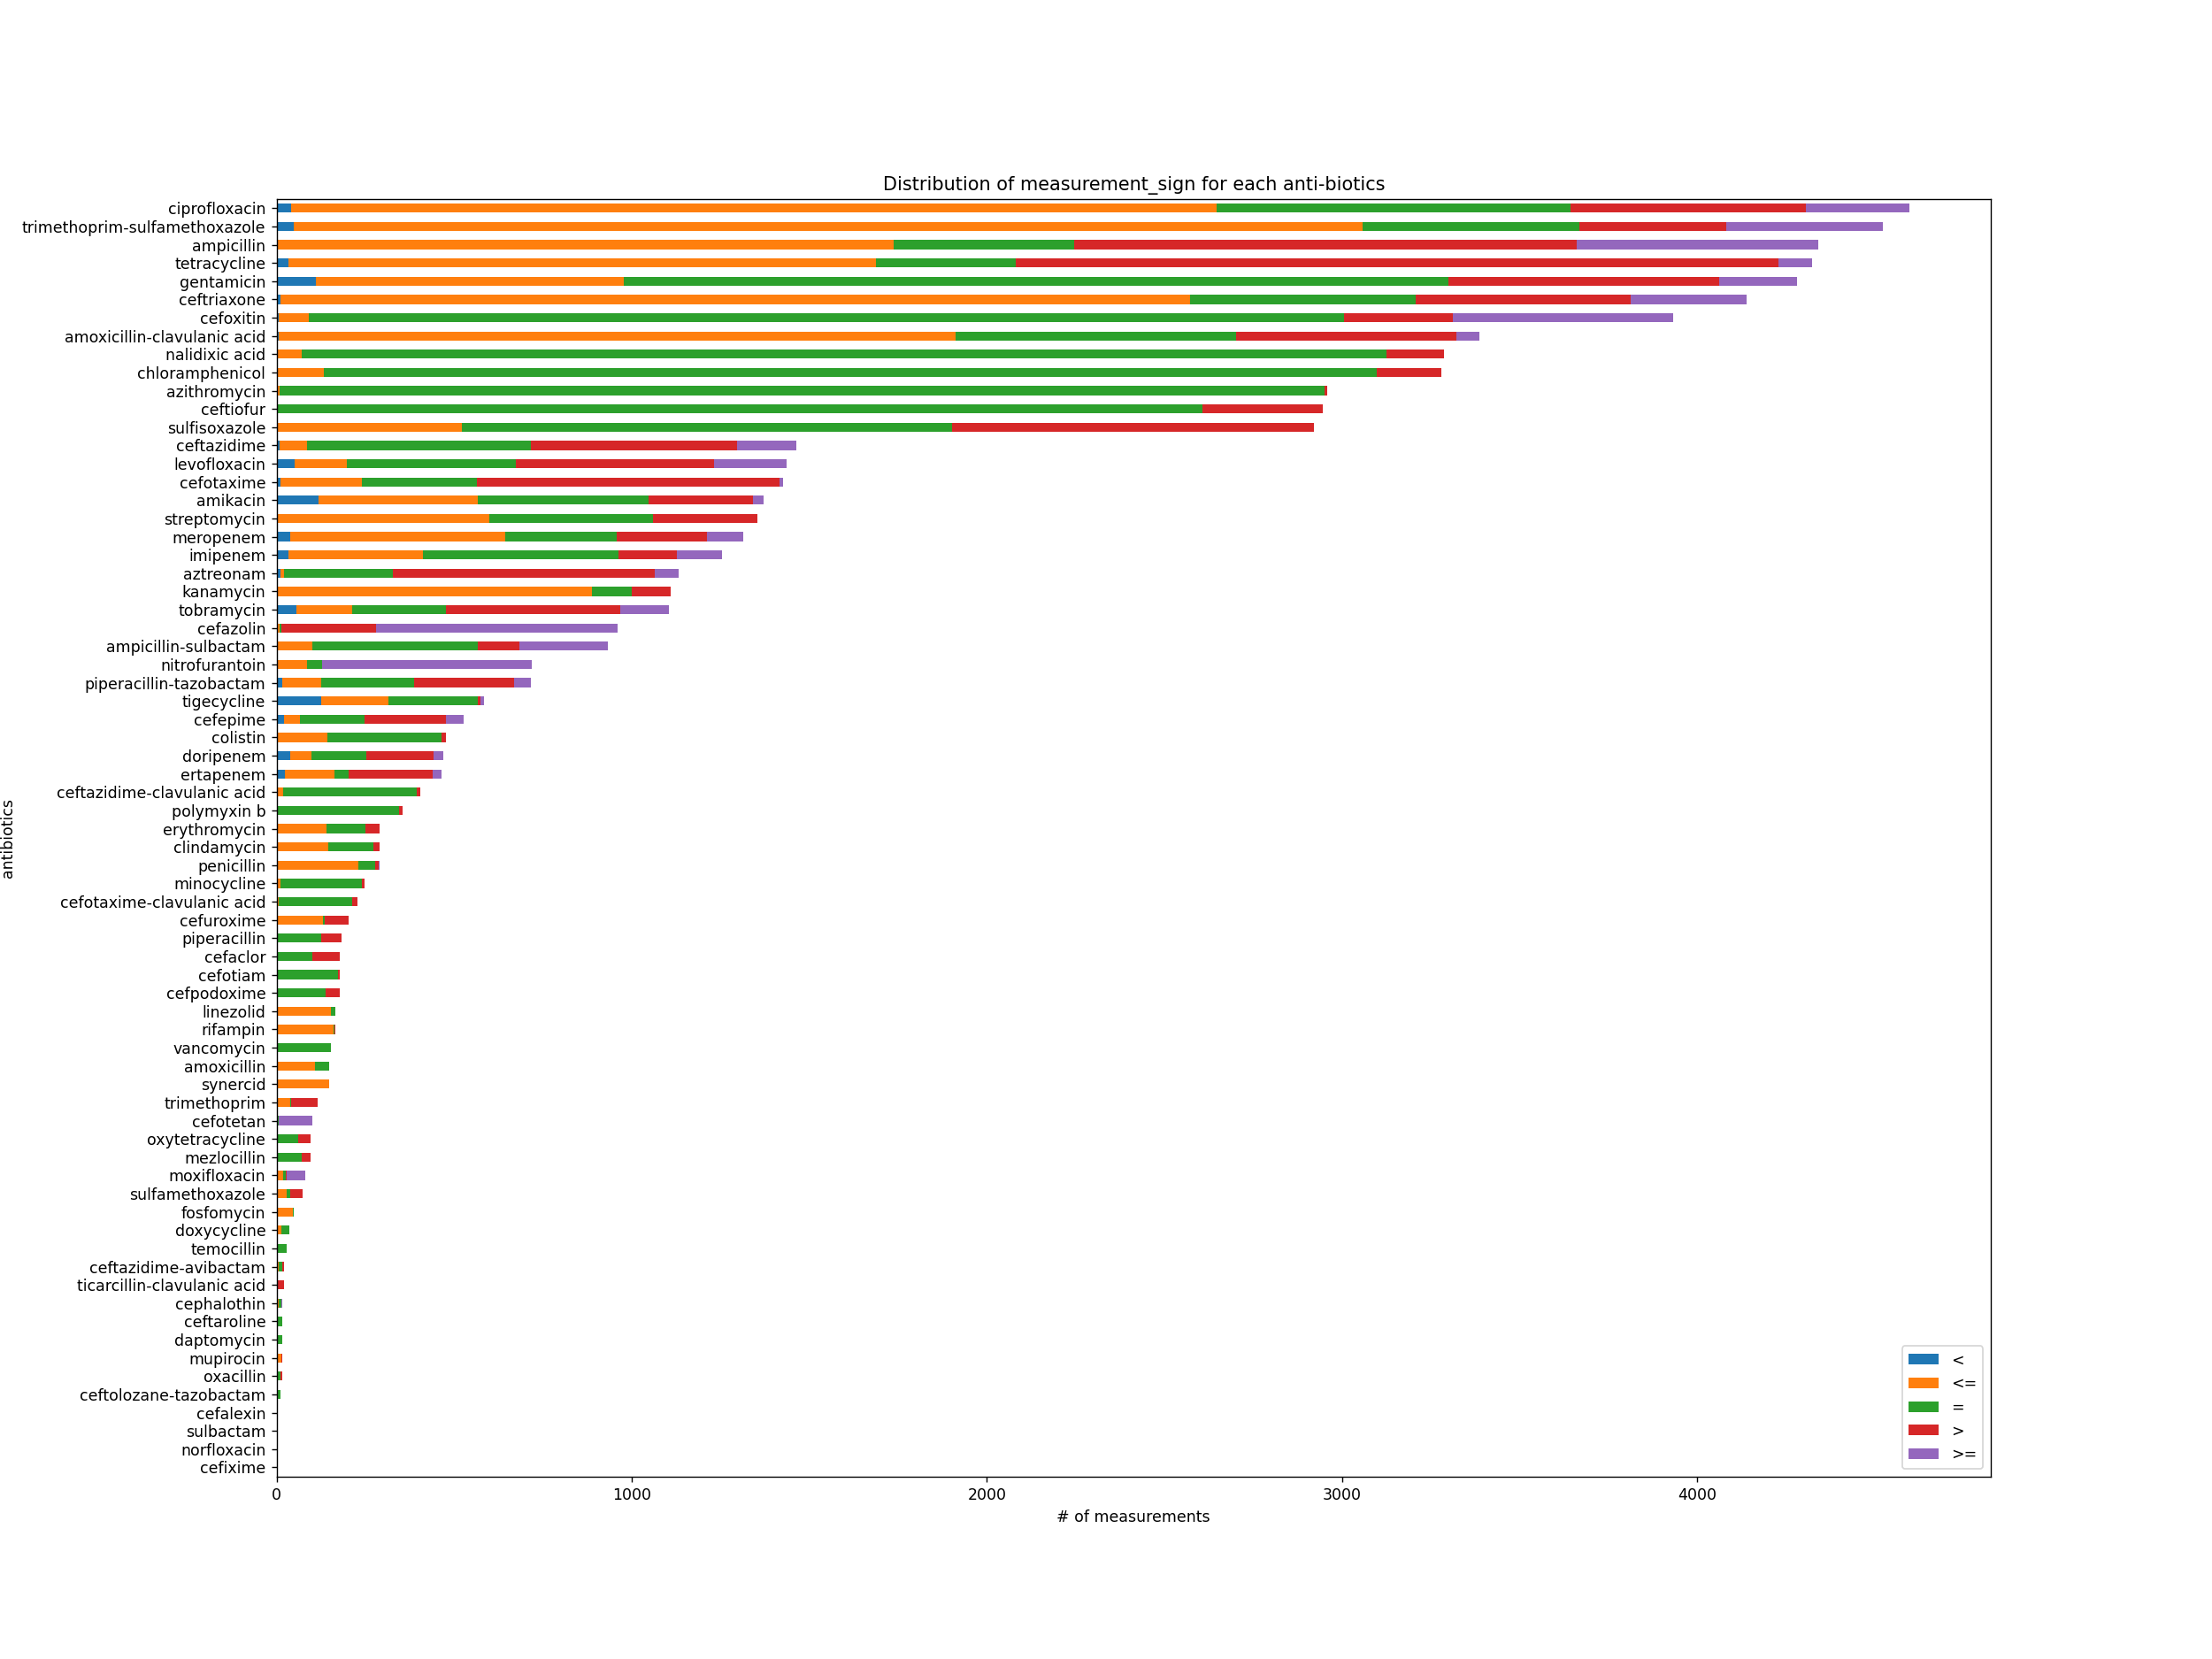

In [34]:
look_at_anti_dist(filtered_ASR, 'measurement_sign', col_order=None)

# Cleaning

In [35]:
filtered_ASR['unique_id'].describe()

count                72352
unique                4736
top       SAMN04448226VAMP
freq                    29
Name: unique_id, dtype: object

In [39]:
filtered_ASR.columns

Index(['Unnamed: 0', 'biosample_id', 'antibiotic_name', 'ast_standard',
       'breakpoint_version', 'laboratory_typing_method', 'measurement',
       'measurement_sign', 'resistance_phenotype', 'platform', 'DB',
       'measurement_has_/', 'measurement2', 'units', 'measurement_type', '1',
       '1.1', '1.2', 'unique_id', 'species_fam'],
      dtype='object')

## bad units

<IPython.core.display.Javascript object>


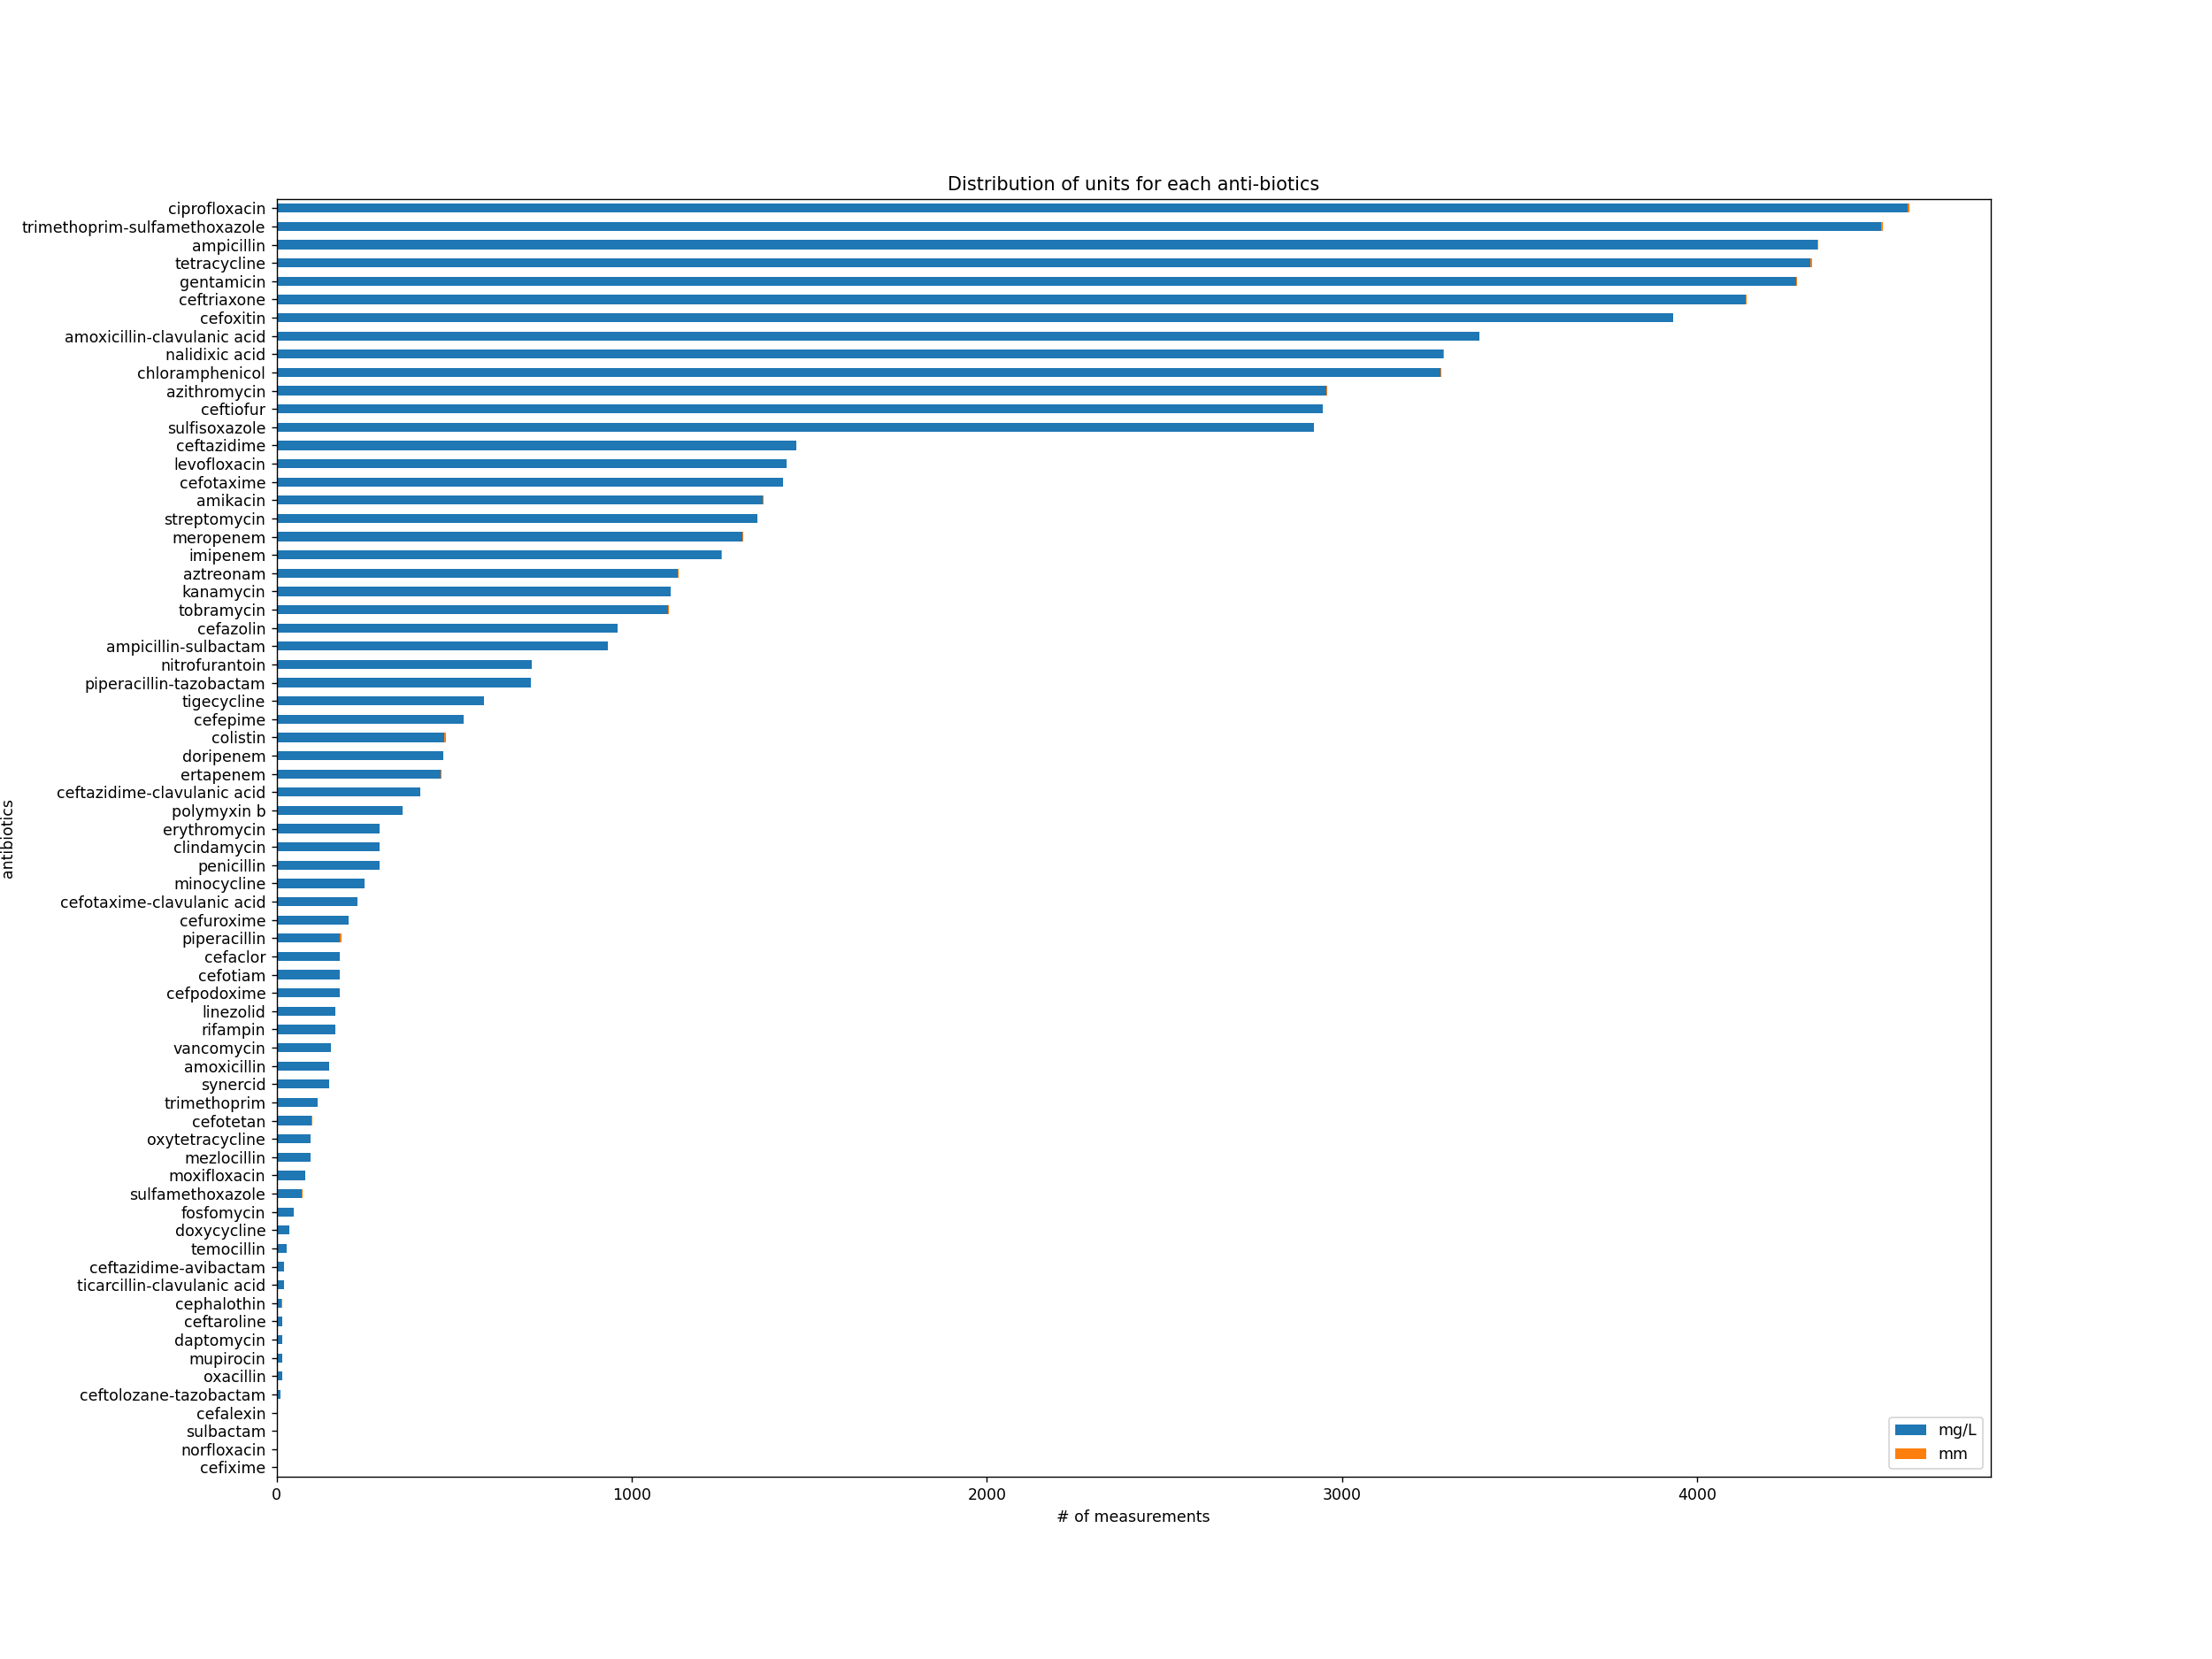

In [36]:
look_at_anti_dist(filtered_ASR, 'units', col_order=None)

In [37]:
filtered_ASR = filtered_ASR[filtered_ASR['units']=='mg/L']

In [38]:
filtered_ASR['unique_id'].describe()

count                72280
unique                4734
top       SAMN04448226VAMP
freq                    29
Name: unique_id, dtype: object

## Filter standard

<IPython.core.display.Javascript object>


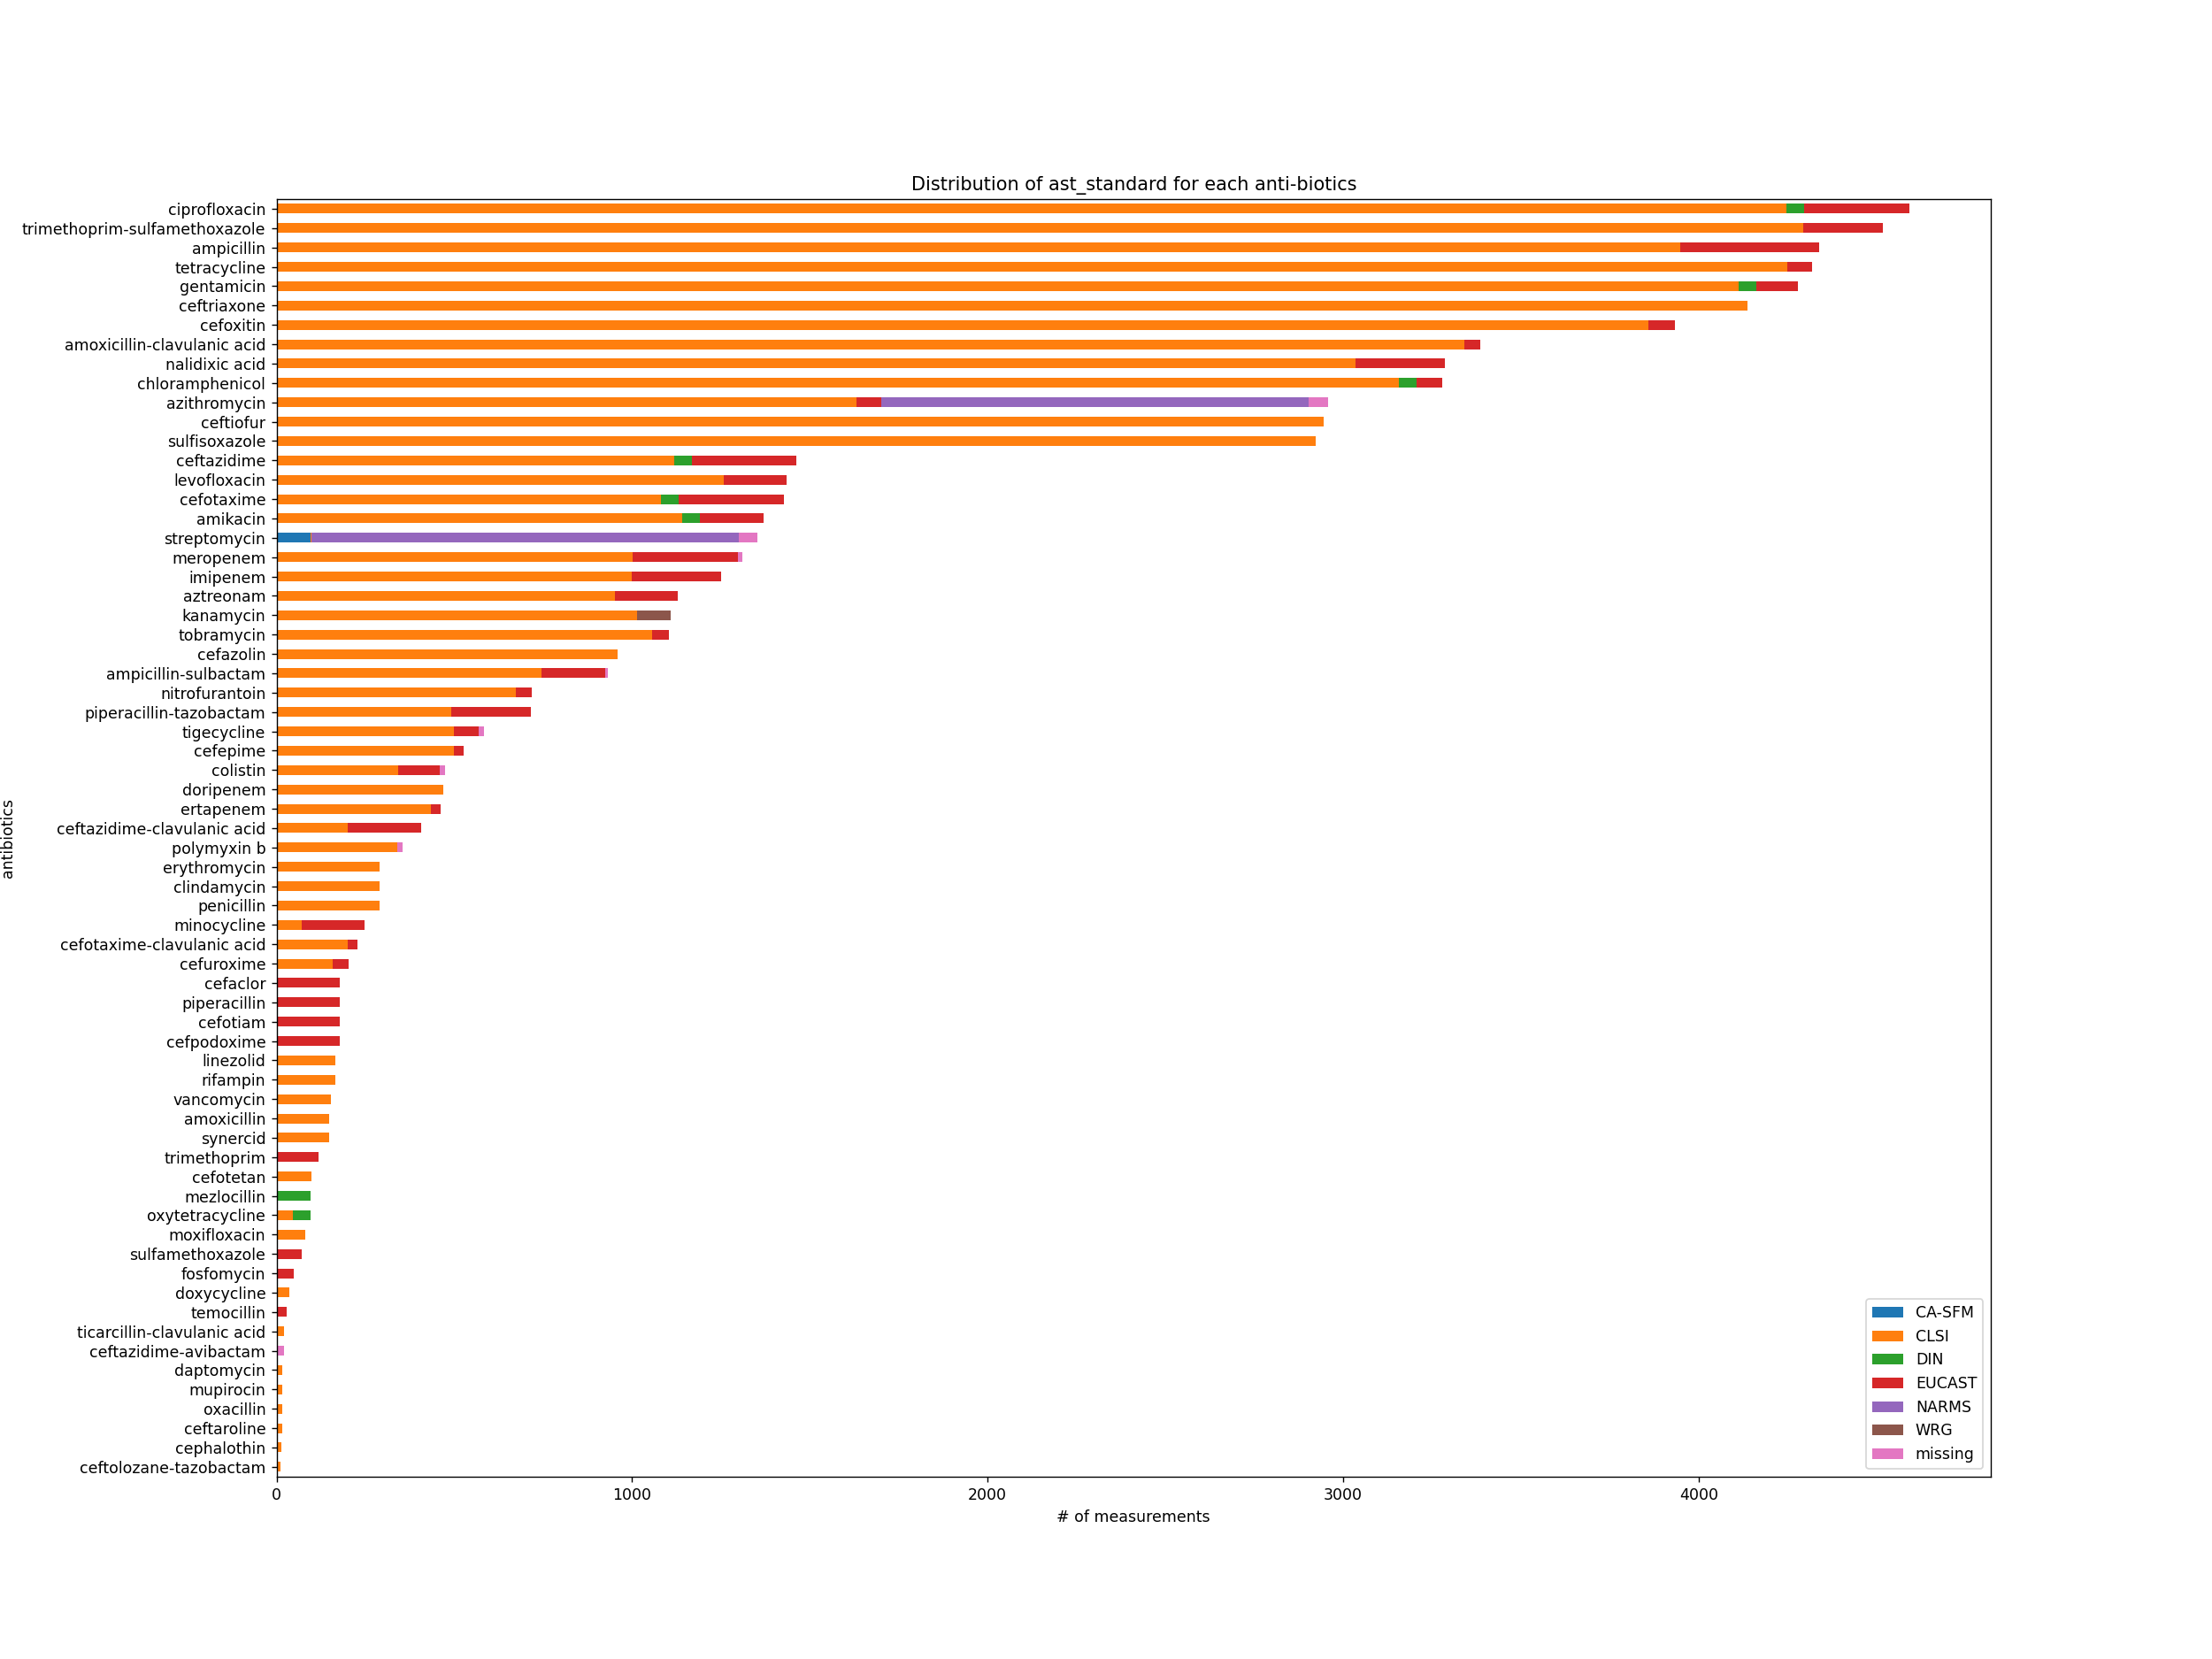

In [40]:
look_at_anti_dist(filtered_ASR, 'ast_standard', col_order=None)

In [41]:
filtered_ASR = filtered_ASR[filtered_ASR['ast_standard']=='CLSI']

In [42]:
filtered_ASR['unique_id'].describe()

count                63594
unique                4439
top       SAMN04448231VAMP
freq                    29
Name: unique_id, dtype: object

## Filter species

<IPython.core.display.Javascript object>


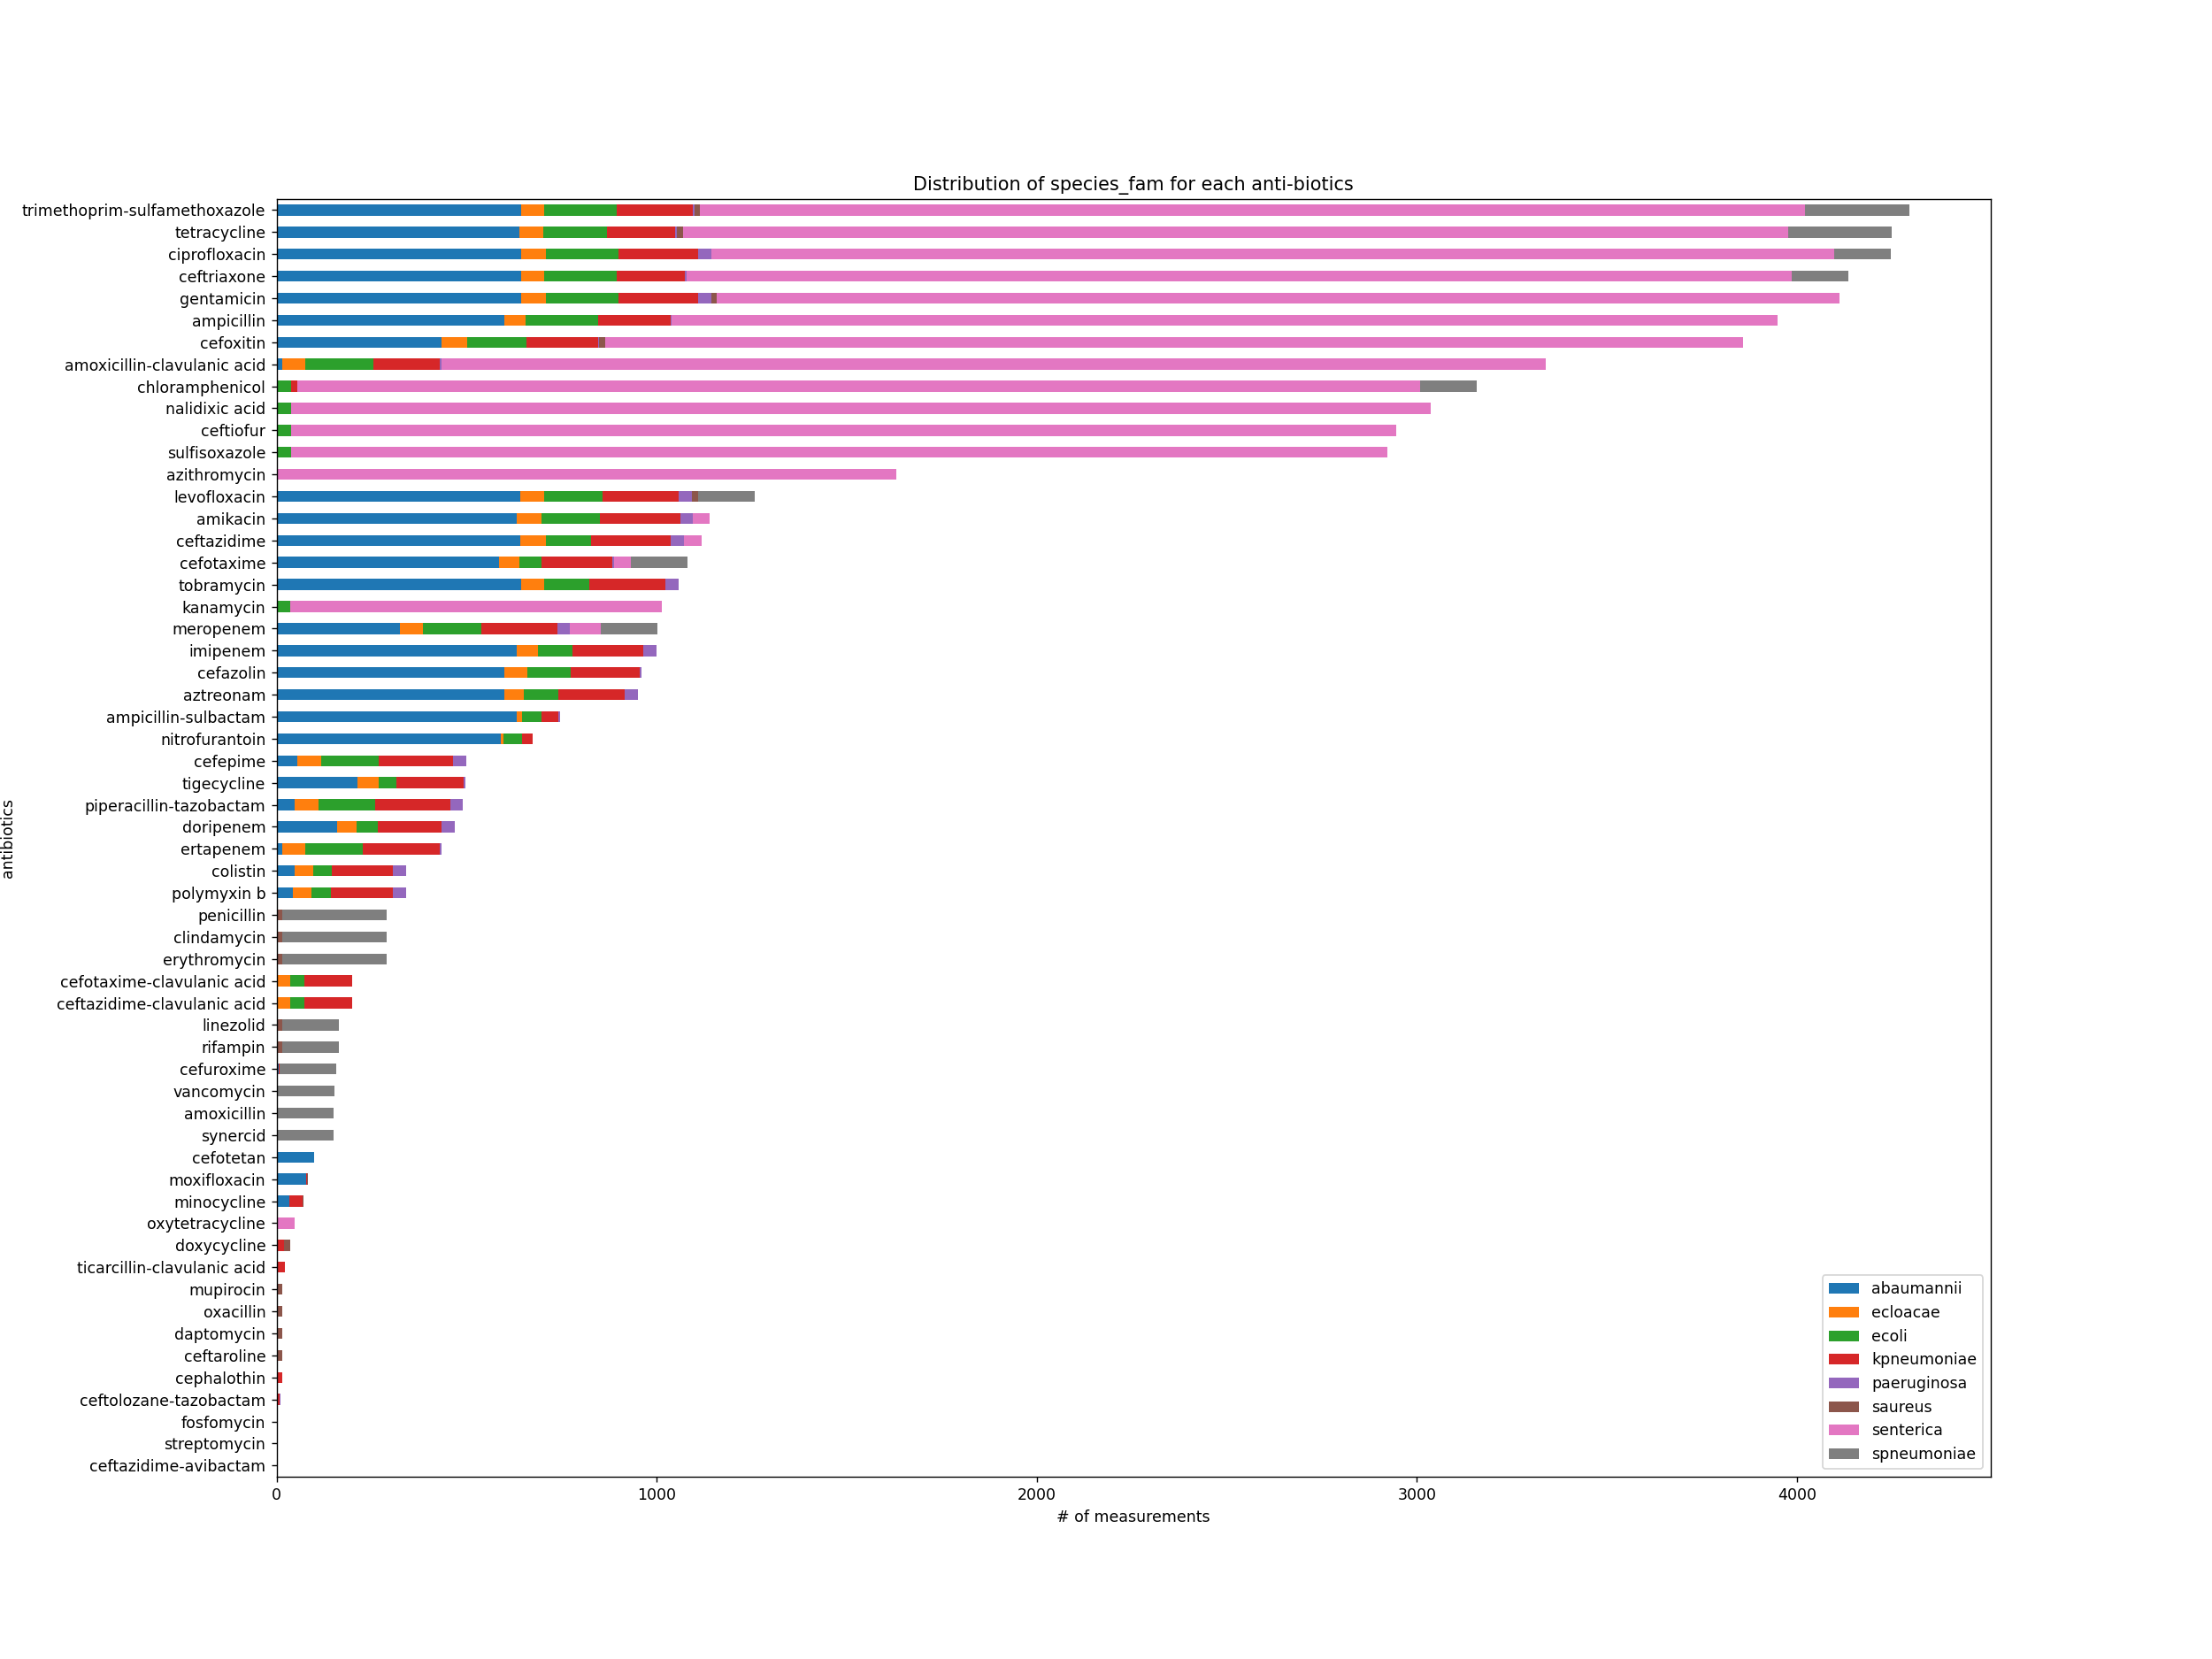

In [43]:
look_at_anti_dist(filtered_ASR, 'species_fam', col_order=None)

In [44]:
filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='senterica']
filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='spneumoniae']

<IPython.core.display.Javascript object>


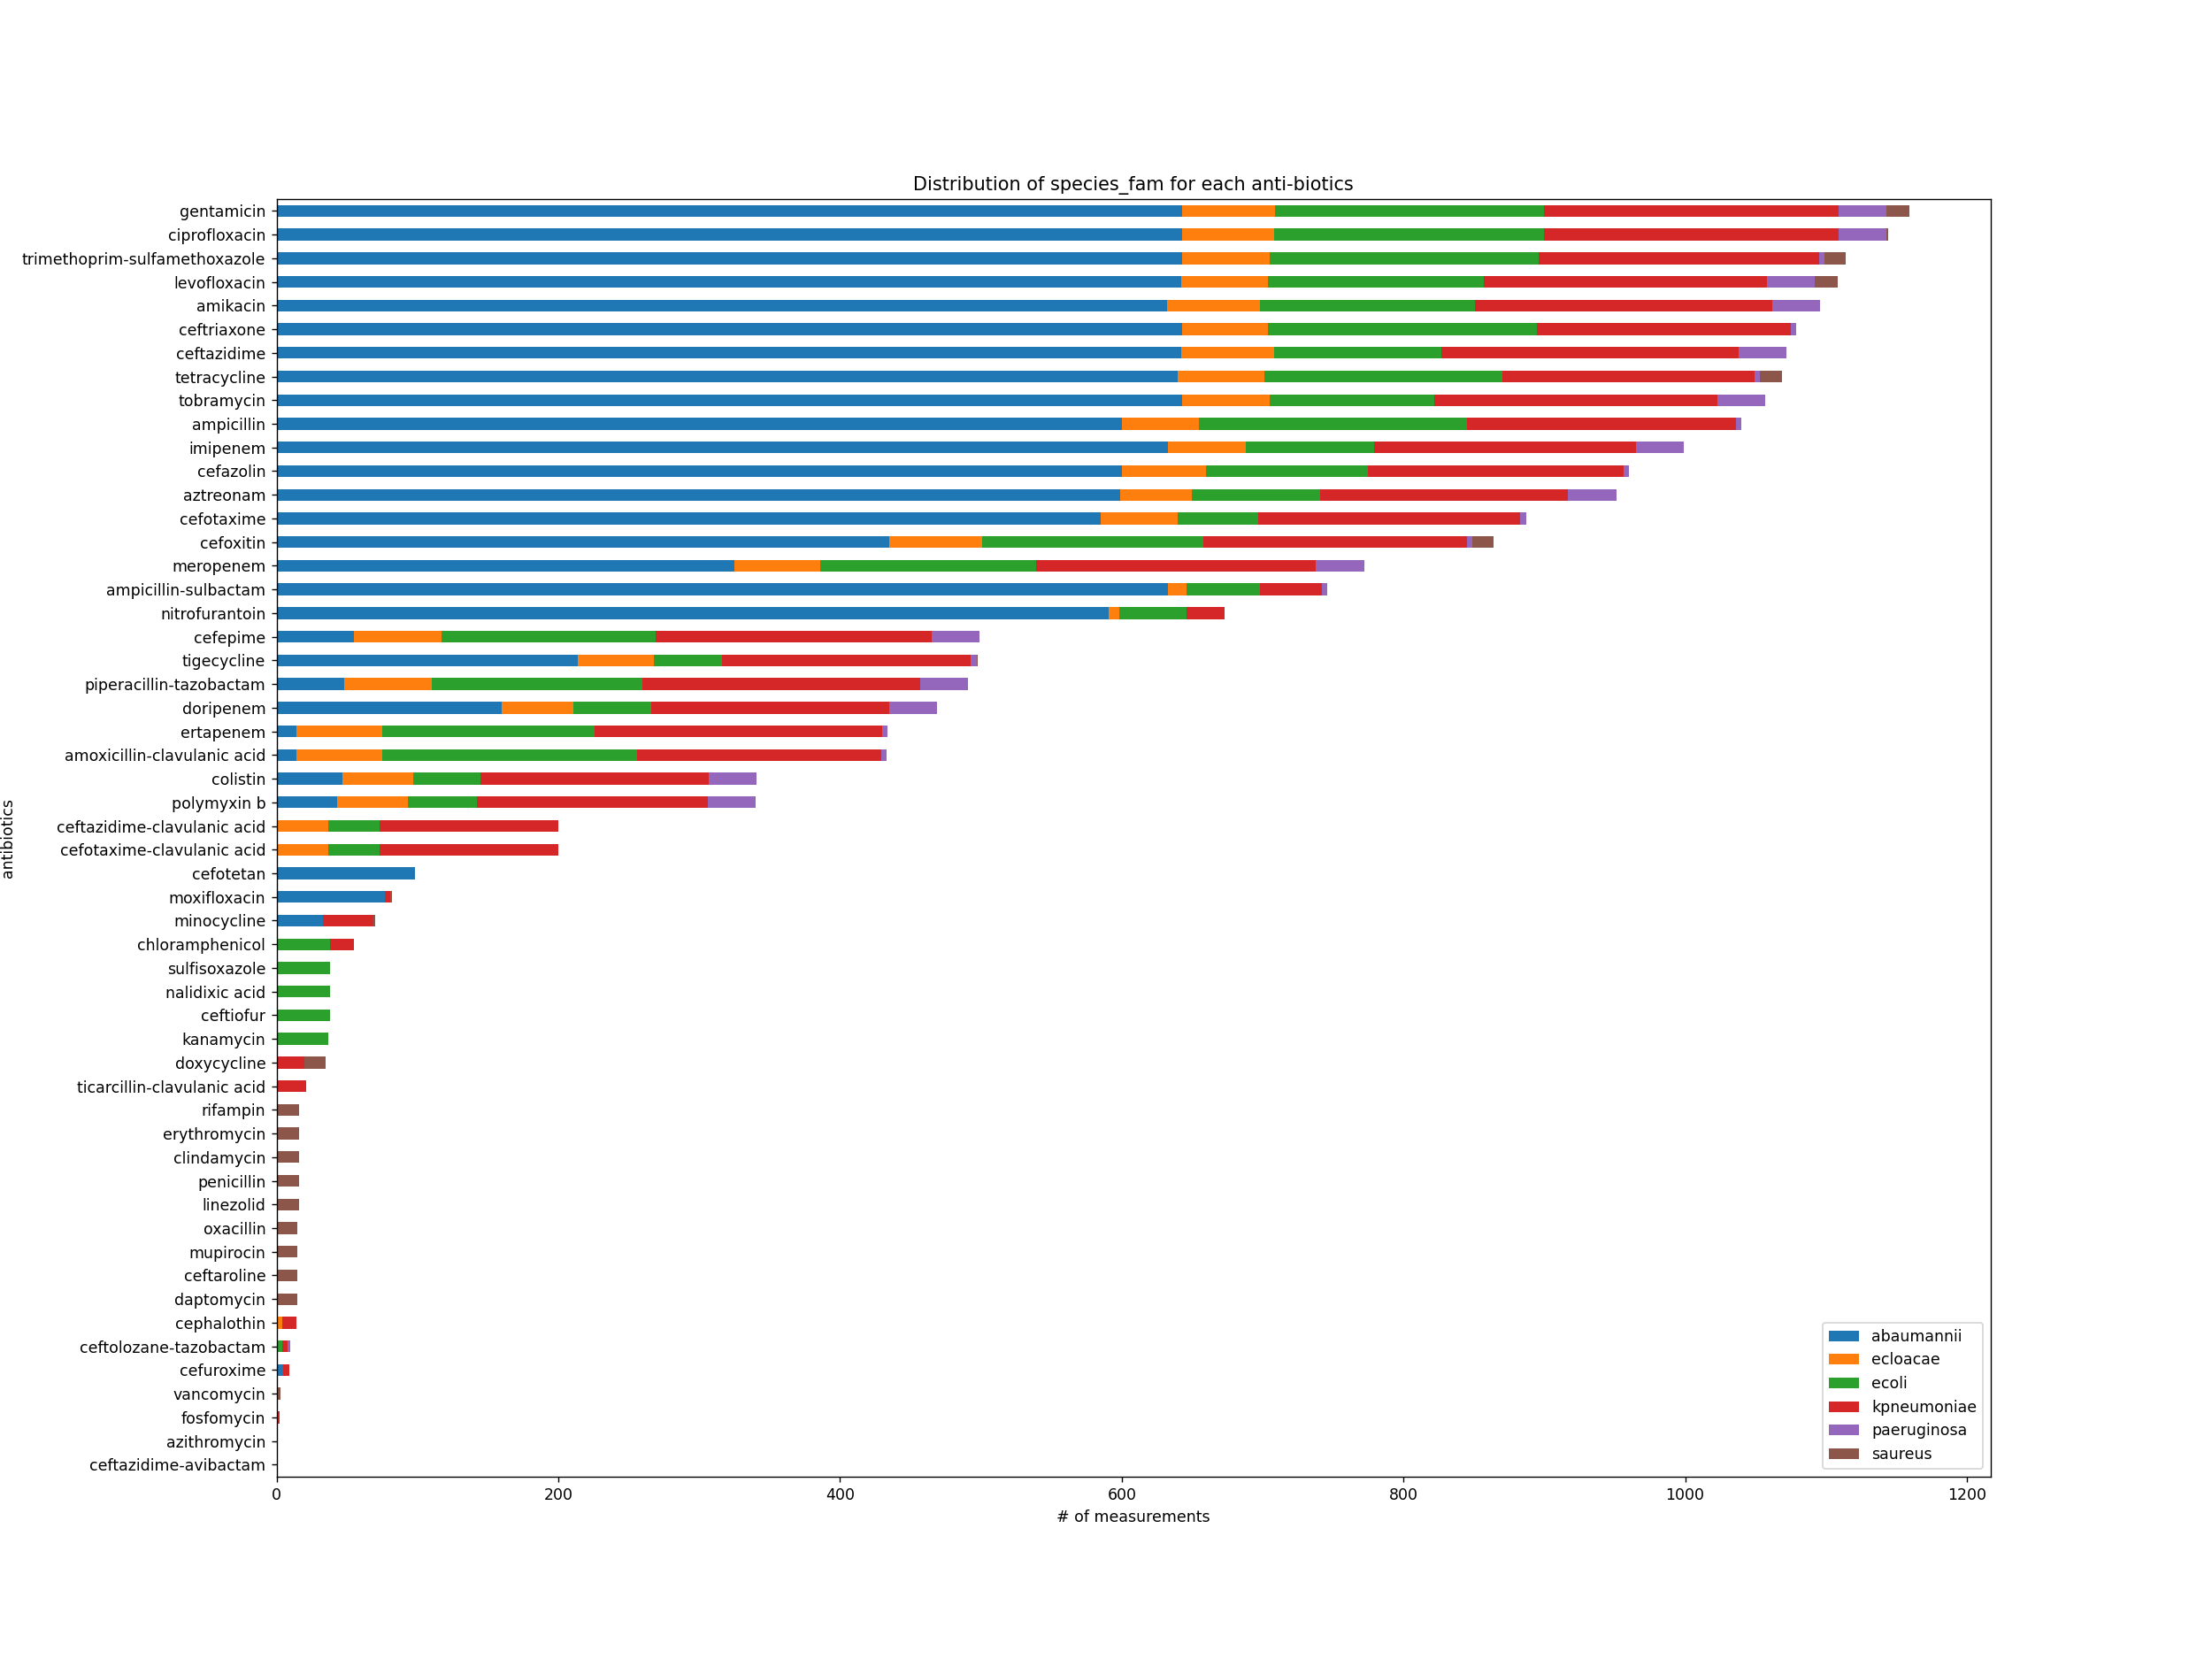

In [45]:
look_at_anti_dist(filtered_ASR, 'species_fam', col_order=None)

In [46]:
species = filtered_ASR['species_fam'].value_counts().reset_index()['index'].iloc[0]
species

'abaumannii'

<IPython.core.display.Javascript object>


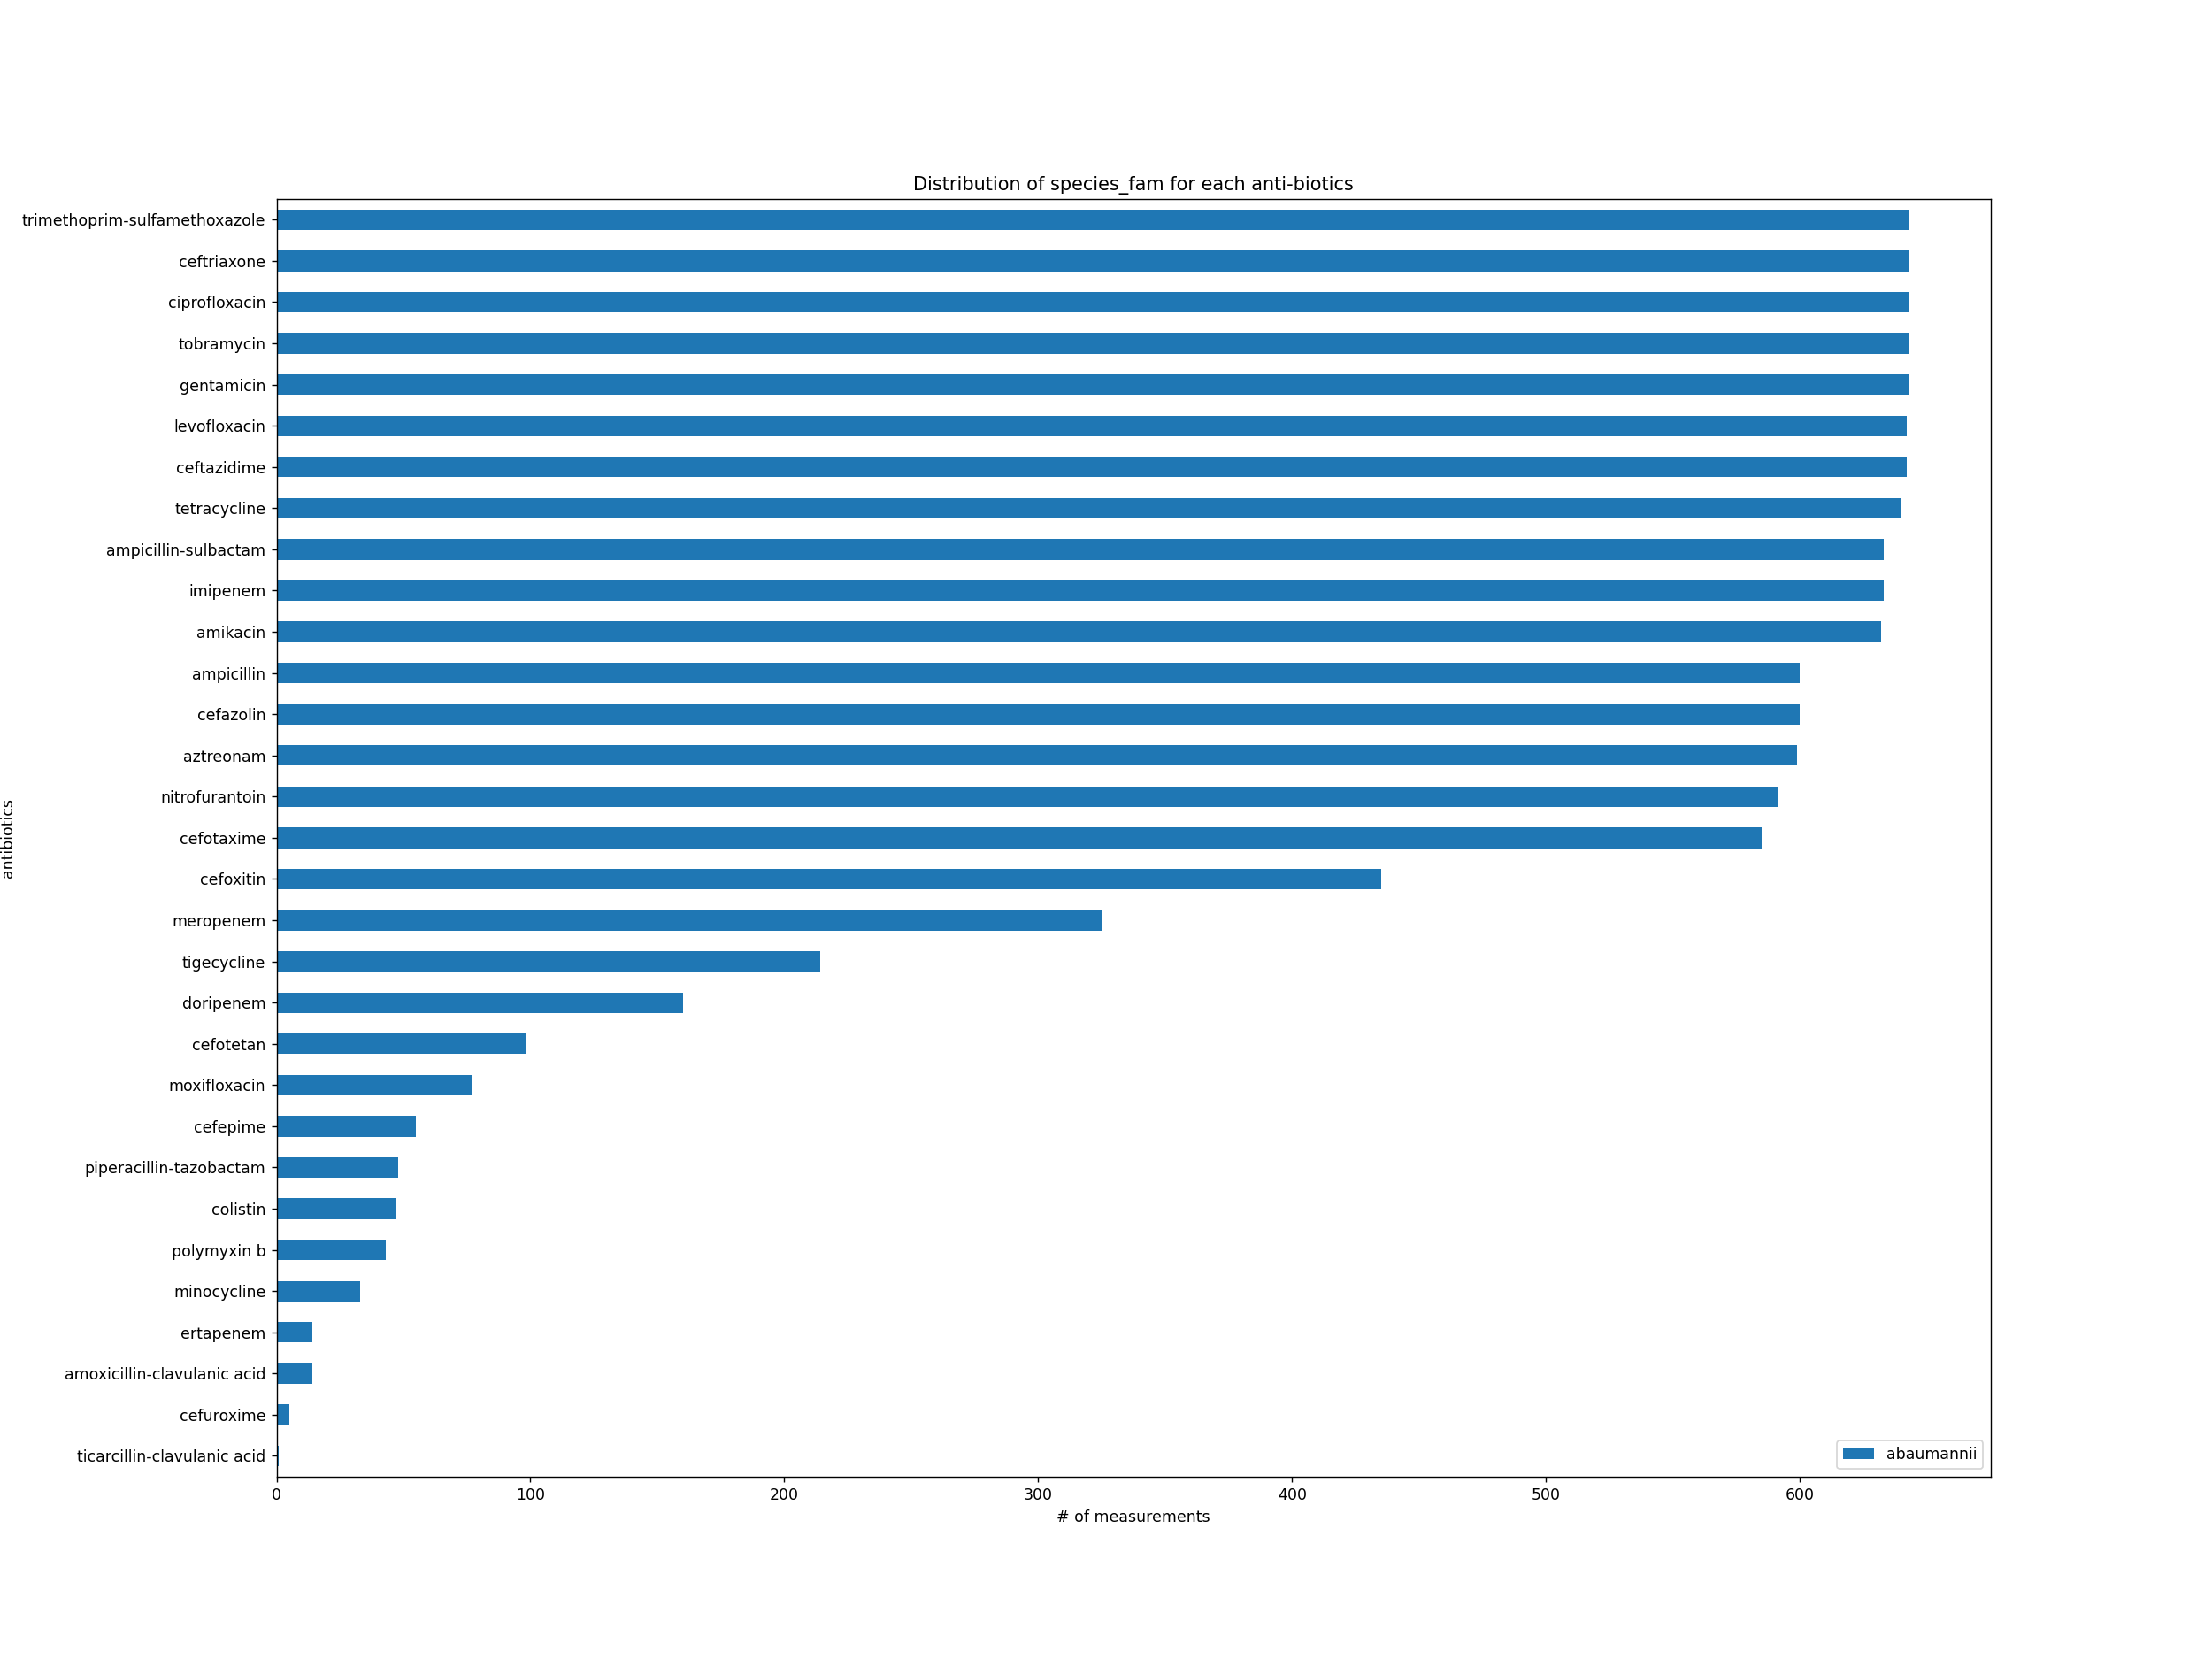

In [47]:
filtered_ASR = filtered_ASR[filtered_ASR['species_fam'] == species]
look_at_anti_dist(filtered_ASR, 'species_fam')

## filter range sighs

In [265]:
# filtered_ASR = filtered_ASR[filtered_ASR['measurement_sign']=='=']

In [48]:
filtered_ASR['unique_id'].describe()

count                11581
unique                 643
top       SAMN04014876VAMP
freq                    25
Name: unique_id, dtype: object

<IPython.core.display.Javascript object>


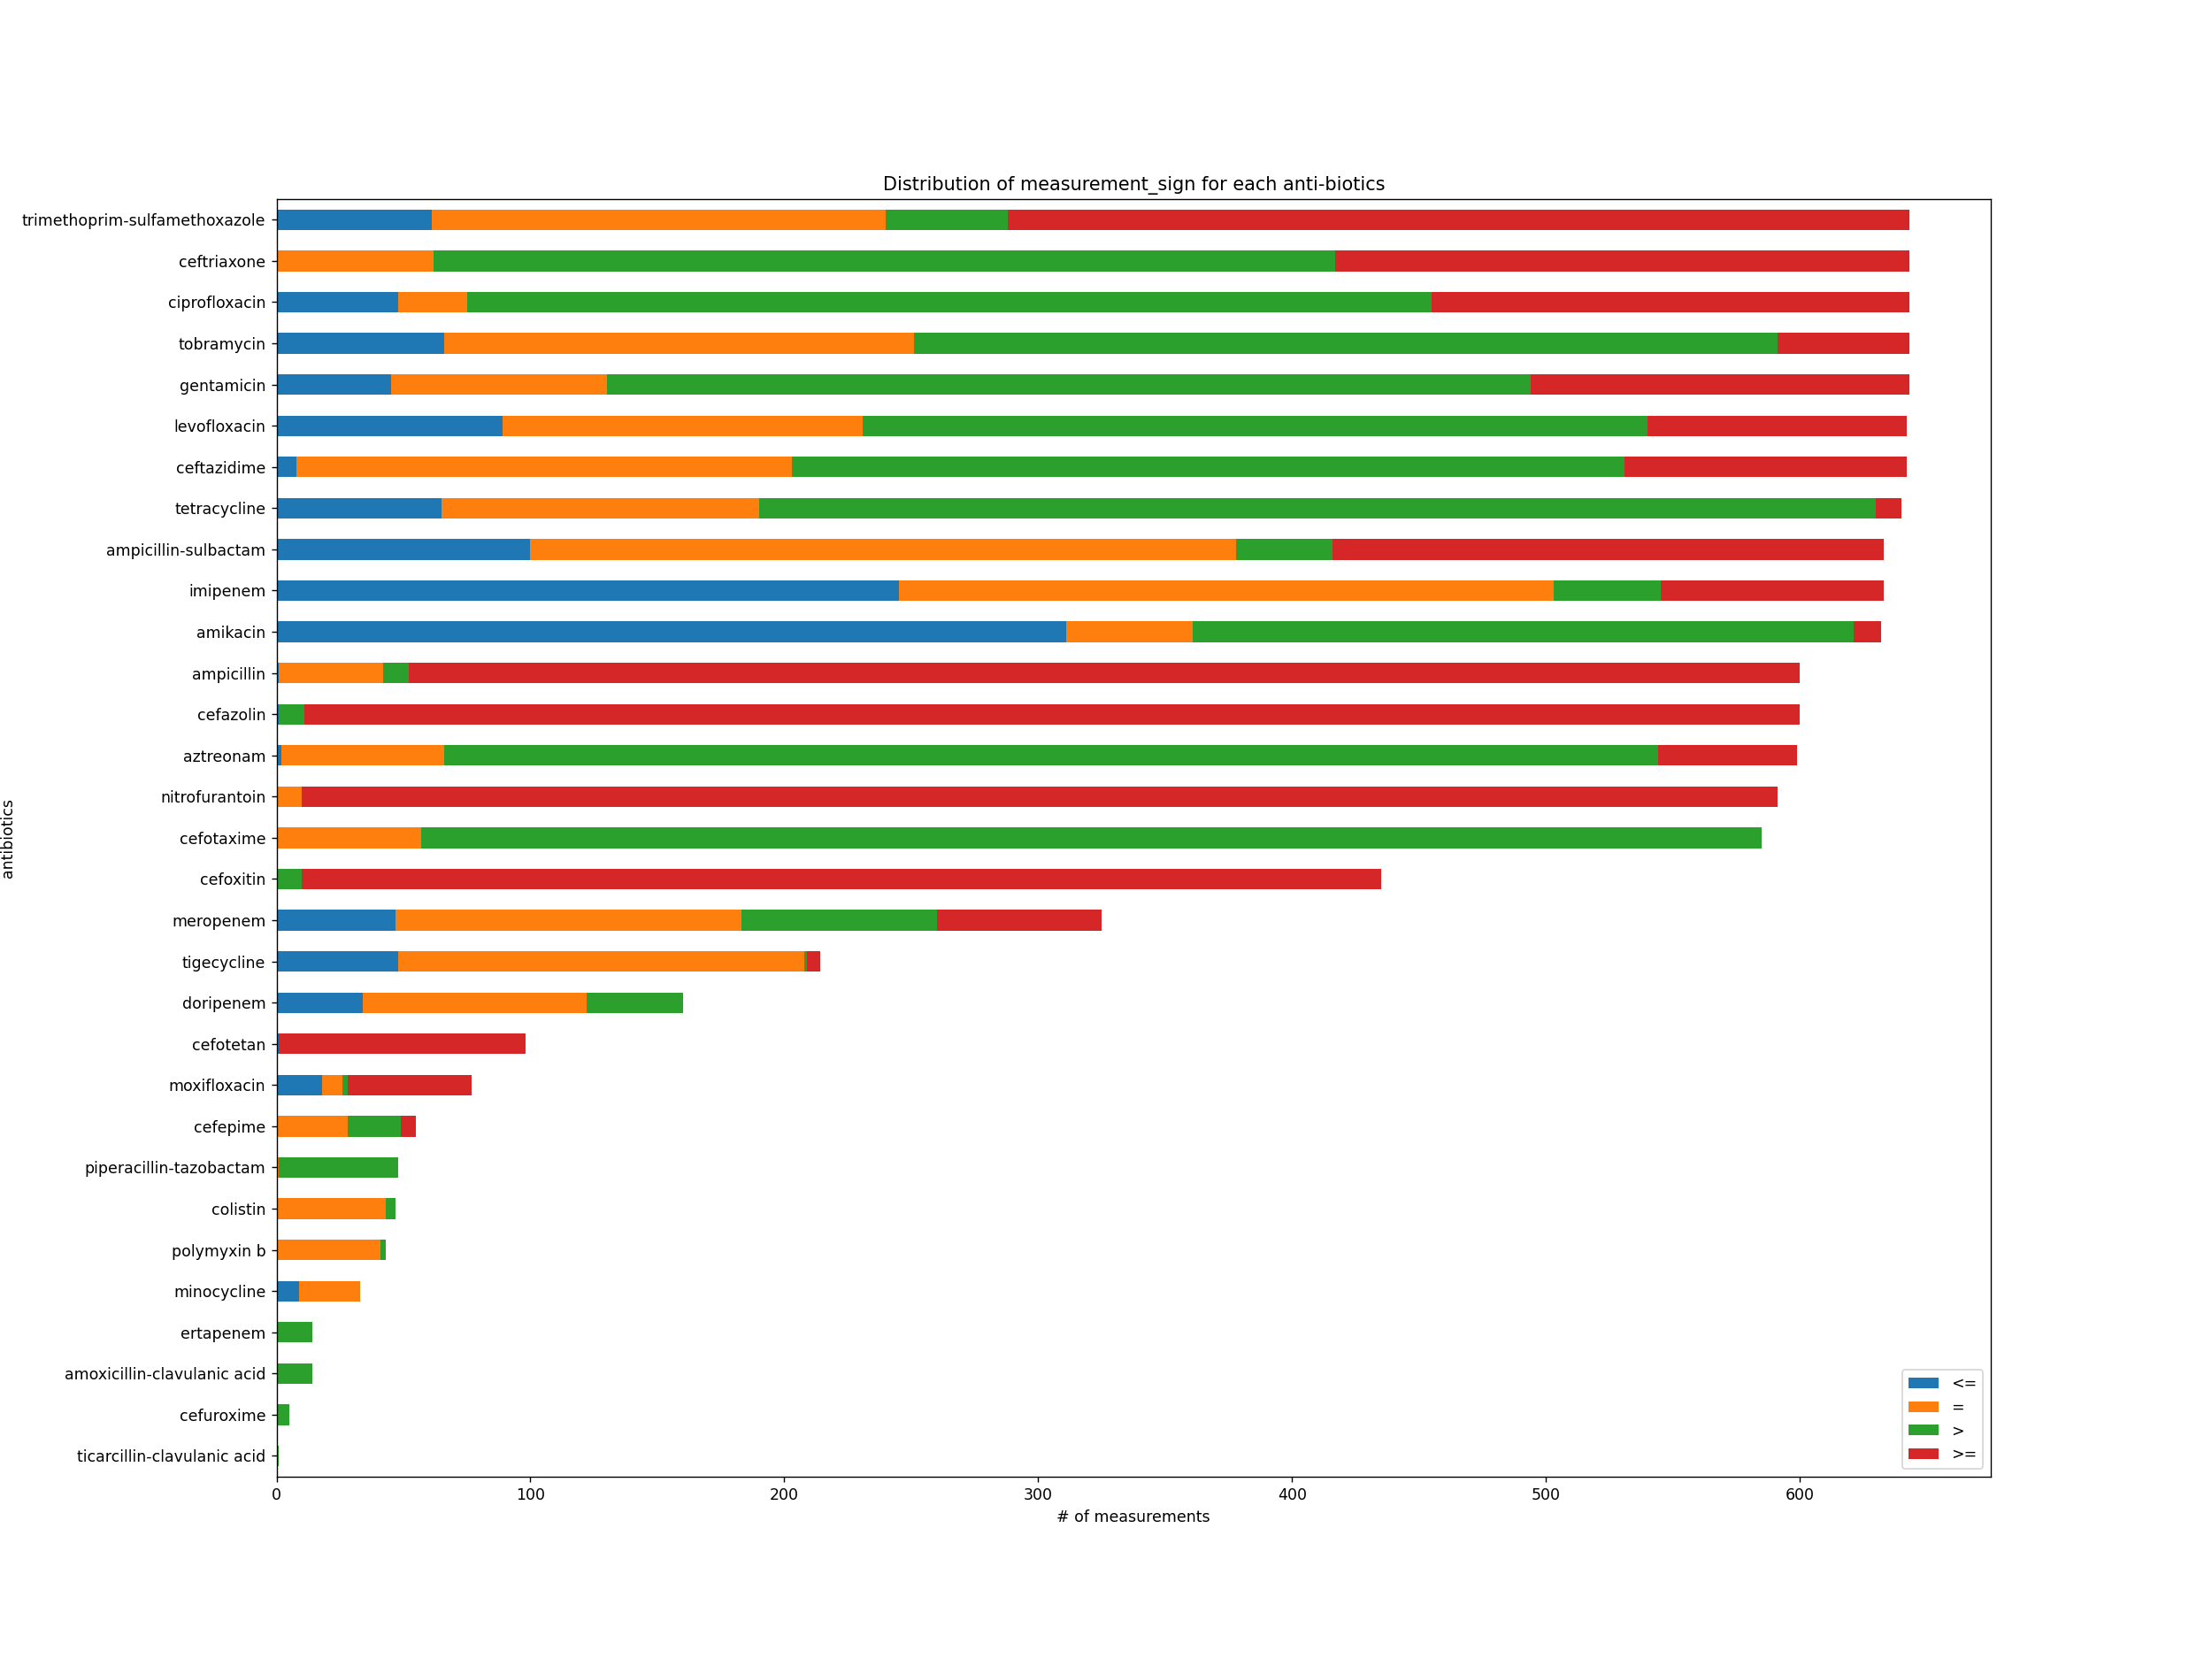

In [49]:
look_at_anti_dist(filtered_ASR, 'measurement_sign', col_order=None)

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


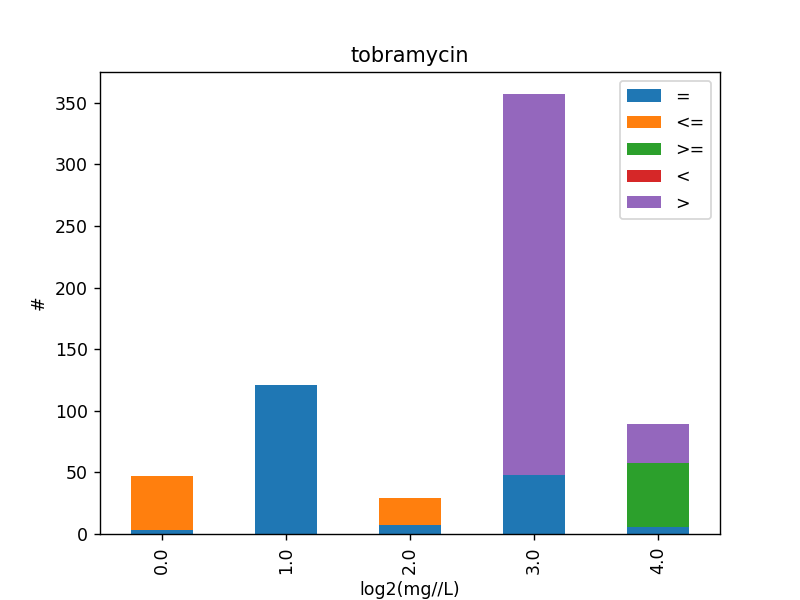

In [27]:
print_anti_measure(filtered_ASR, 0)

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


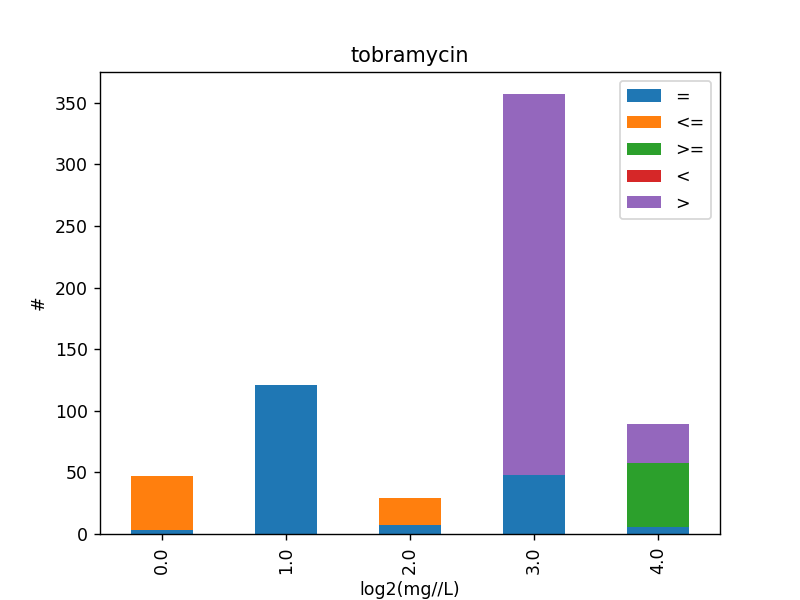

<IPython.core.display.Javascript object>


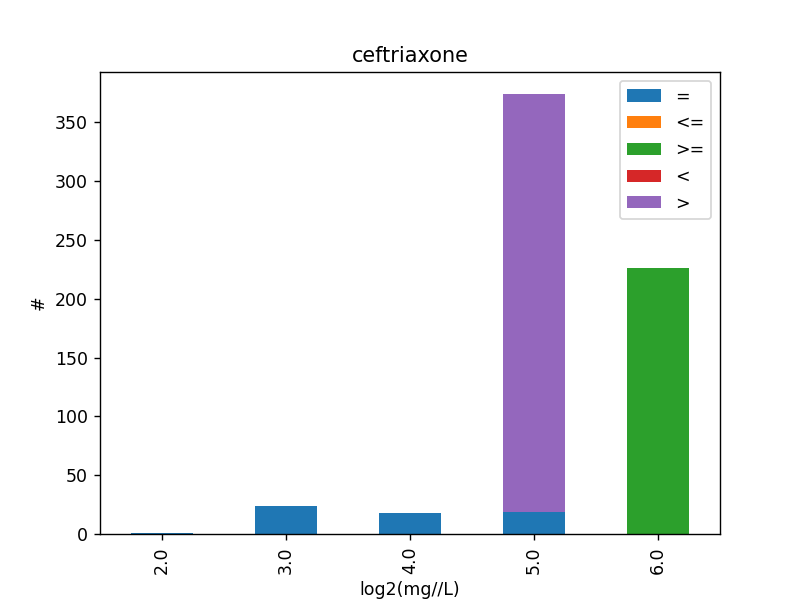

<IPython.core.display.Javascript object>


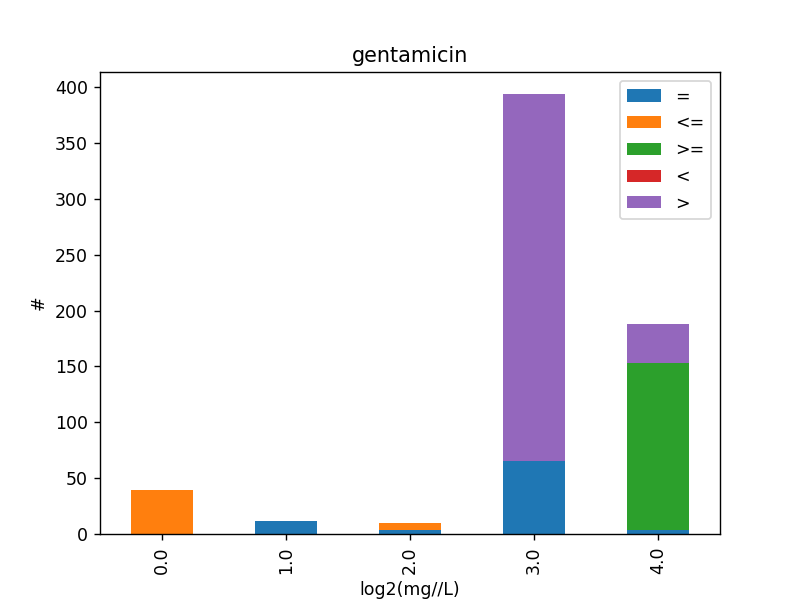

<IPython.core.display.Javascript object>


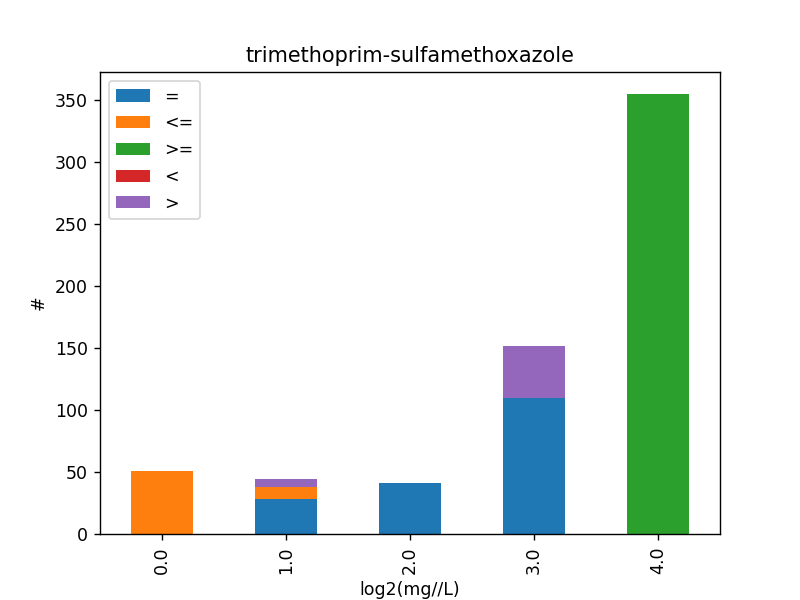

<IPython.core.display.Javascript object>


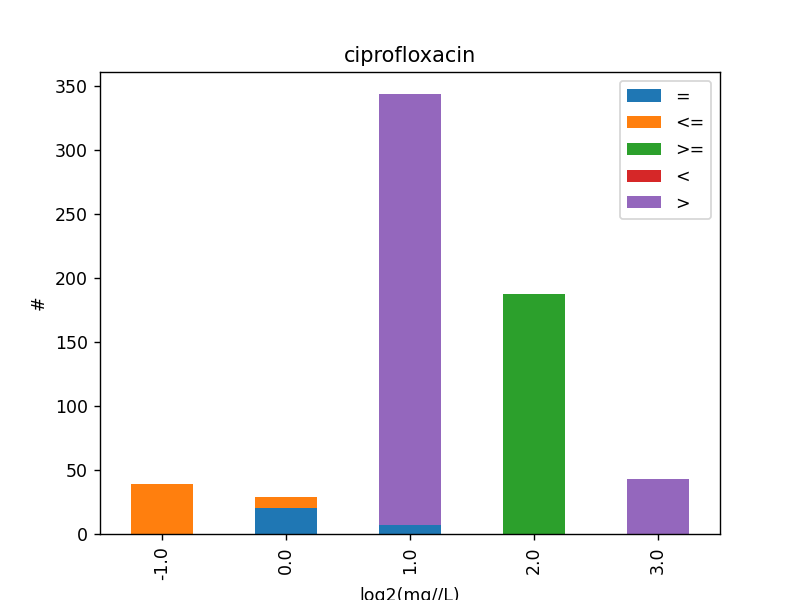

<IPython.core.display.Javascript object>


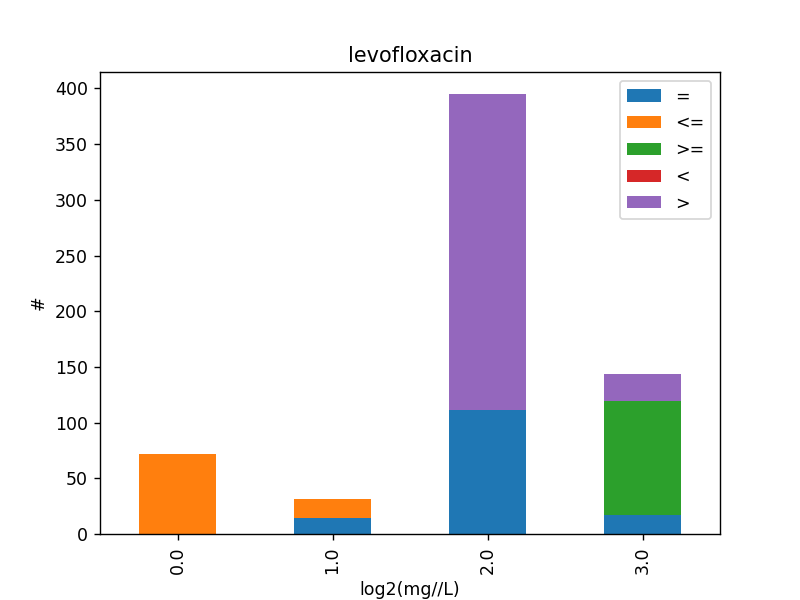

<IPython.core.display.Javascript object>


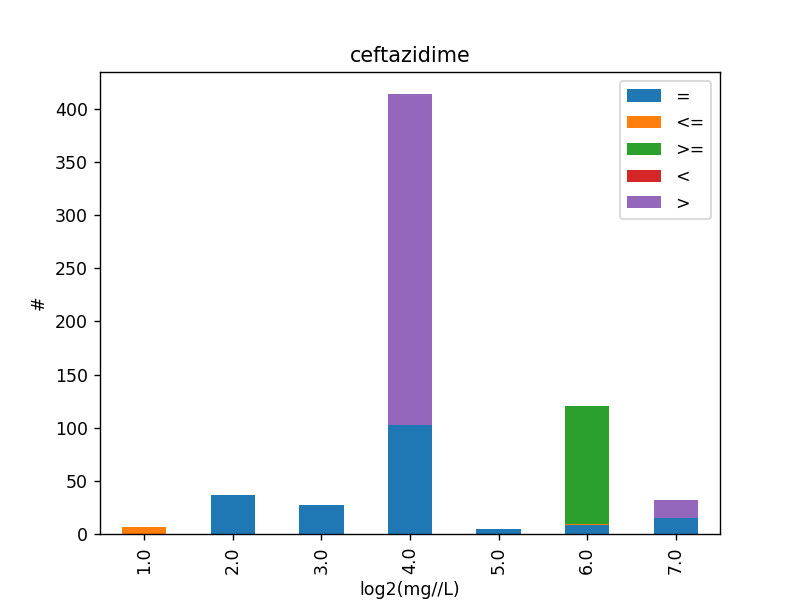

<IPython.core.display.Javascript object>


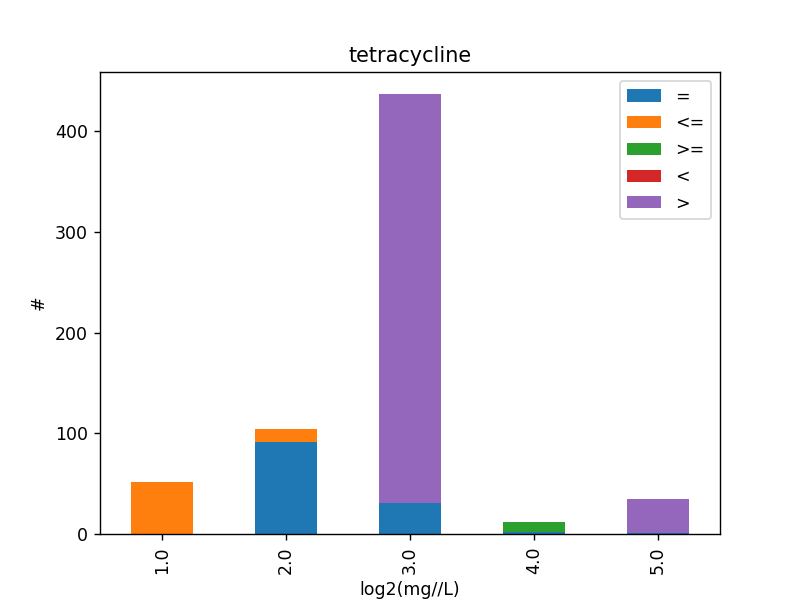

<IPython.core.display.Javascript object>


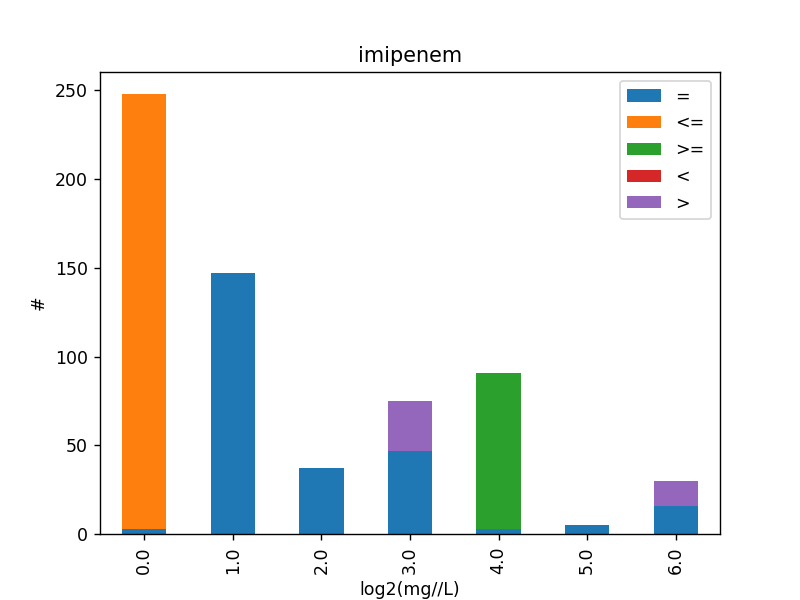

<IPython.core.display.Javascript object>


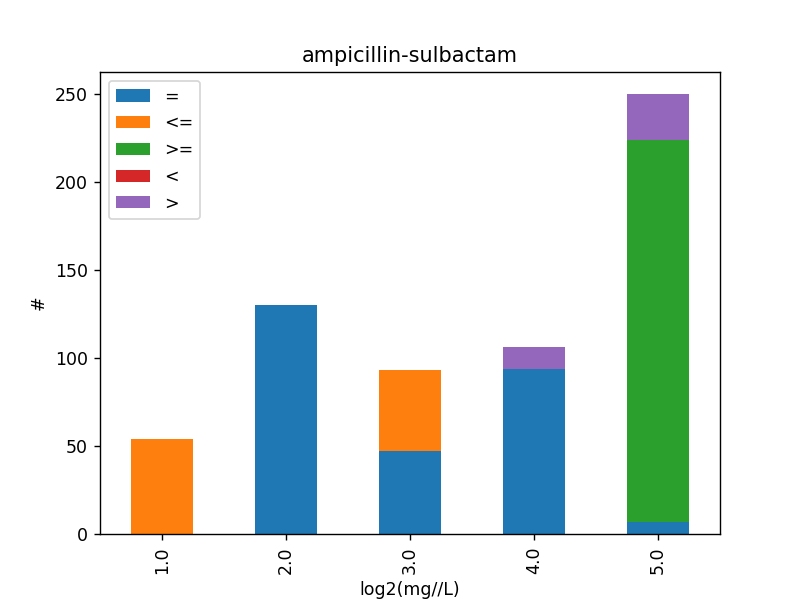

In [28]:
for i in np.arange(10):
    print_anti_measure(filtered_ASR, i)

## list of valid labels:

In [29]:
filtered_ASR['antibiotic_name'].value_counts()

tobramycin                       643
ceftriaxone                      643
gentamicin                       643
trimethoprim-sulfamethoxazole    643
ciprofloxacin                    643
levofloxacin                     642
ceftazidime                      642
tetracycline                     640
imipenem                         633
ampicillin-sulbactam             633
amikacin                         632
ampicillin                       600
cefazolin                        600
aztreonam                        599
nitrofurantoin                   591
cefotaxime                       585
cefoxitin                        435
meropenem                        325
tigecycline                      214
doripenem                        160
cefotetan                         98
moxifloxacin                      77
cefepime                          55
piperacillin-tazobactam           48
colistin                          47
polymyxin b                       43
minocycline                       33
a

In [30]:
anti_list = filtered_ASR['antibiotic_name'].value_counts().index.values

In [31]:
anti_list

array(['tobramycin', 'ceftriaxone', 'gentamicin',
       'trimethoprim-sulfamethoxazole', 'ciprofloxacin', 'levofloxacin',
       'ceftazidime', 'tetracycline', 'imipenem', 'ampicillin-sulbactam',
       'amikacin', 'ampicillin', 'cefazolin', 'aztreonam',
       'nitrofurantoin', 'cefotaxime', 'cefoxitin', 'meropenem',
       'tigecycline', 'doripenem', 'cefotetan', 'moxifloxacin',
       'cefepime', 'piperacillin-tazobactam', 'colistin', 'polymyxin b',
       'minocycline', 'amoxicillin-clavulanic acid', 'ertapenem',
       'cefuroxime', 'ticarcillin-clavulanic acid'], dtype=object)

In [20]:
filtered_ASR.set_index('unique_id', inplace=True)

## set general data columns

In [21]:
data.set_index('unique_id', inplace=True)

In [22]:
data.columns

Index(['Unnamed: 0', 'species_fam', 'run_id', 'biosample_id', 'nitrofurantoin',
       'piperacillin-tazobactam', 'amikacin', 'cefazolin', 'cefepime',
       'cefoxitin',
       ...
       'vatF->seq_id', 'vatF->seq_cov', 'CTX-M-24->seq_id',
       'CTX-M-24->seq_cov', 'TEM-63->seq_id', 'TEM-63->seq_cov',
       'ACT-22->seq_id', 'ACT-22->seq_cov', 'CTX-M-66->seq_id',
       'CTX-M-66->seq_cov'],
      dtype='object', length=1289)

In [23]:
data.drop(['Unnamed: 0', 'species_fam', 'run_id', 'biosample_id'], axis=1, inplace=True)

In [24]:
data

nitrofurantoin piperacillin-tazobactam amikacin cefazolin  \
unique_id                                                                      
SAMN04229826VAMP           >= 9.0                     NaN   <= 4.0    >= 6.0   
SAMN04229822VAMP           >= 9.0                     NaN      NaN    >= 6.0   
SAMN04229823VAMP           >= 9.0                     NaN    > 5.0    >= 6.0   
SAMN04229824VAMP           >= 9.0                     NaN   <= 4.0    >= 6.0   
SAMN04229825VAMP           >= 9.0                     NaN   <= 4.0    >= 6.0   
...                           ...                     ...      ...       ...   
SAMN02912014PATAKI            NaN                     NaN      NaN       NaN   
SAMN02912015PATAKI            NaN                     NaN      NaN       NaN   
SAMN05416460PATAKI            NaN                     NaN      NaN       NaN   
SAMN05416461PATAKI            NaN                     NaN      NaN       NaN   
SAMN05416462PATAKI            NaN                     NaN      NaN       NaN   

                   cefepime cefoxitin ceftazidime ceftriaxone meropenem  \
unique_id                                                                 
SAMN04229826VAMP        NaN    >= 6.0      >= 6.0      >= 6.0       NaN   
SAMN04229822VAMP        NaN       NaN         NaN      >= 6.0     = 1.0   
SAMN04229823VAMP        NaN       NaN       = 3.0      >= 6.0     = 0.0   
SAMN04229824VAMP        NaN       NaN       > 4.0      >= 6.0     = 1.0   
SAMN04229825VAMP        NaN       NaN       > 4.0      >= 6.0     = 2.0   
...                     ...       ...         ...         ...       ...   
SAMN02912014PATAKI      NaN     = 1.0         NaN     <= -2.0       NaN   
SAMN02912015PATAKI      NaN     = 1.0         NaN     <= -2.0       NaN   
SAMN05416460PATAKI      NaN     = 1.0         NaN     <= -2.0       NaN   
SAMN05416461PATAKI      NaN     = 2.0         NaN     <= -2.0       NaN   
SAMN05416462PATAKI      NaN     = 2.0         NaN     <= -2.0       NaN   

                   amoxicillin-clavulanic acid  ... vatF->seq_id  \
unique_id                                       ...                
SAMN04229826VAMP                           NaN  ...          NaN   
SAMN04229822VAMP                           NaN  ...          NaN   
SAMN04229823VAMP                           NaN  ...          NaN   
SAMN04229824VAMP                           NaN  ...          NaN   
SAMN04229825VAMP                           NaN  ...          NaN   
...                                        ...  ...          ...   
SAMN02912014PATAKI                      <= 0.0  ...          NaN   
SAMN02912015PATAKI                      <= 0.0  ...          NaN   
SAMN05416460PATAKI                      <= 0.0  ...          NaN   
SAMN05416461PATAKI                      <= 0.0  ...          NaN   
SAMN05416462PATAKI                      <= 0.0  ...          NaN   

                   vatF->seq_cov CTX-M-24->seq_id CTX-M-24->seq_cov  \
unique_id                                                             
SAMN04229826VAMP             NaN              NaN               NaN   
SAMN04229822VAMP             NaN              NaN               NaN   
SAMN04229823VAMP             NaN              NaN               NaN   
SAMN04229824VAMP             NaN              NaN               NaN   
SAMN04229825VAMP             NaN              NaN               NaN   
...                          ...              ...               ...   
SAMN02912014PATAKI           NaN              NaN               NaN   
SAMN02912015PATAKI           NaN              NaN               NaN   
SAMN05416460PATAKI           NaN              NaN               NaN   
SAMN05416461PATAKI           NaN              NaN               NaN   
SAMN05416462PATAKI           NaN              NaN               NaN   

                   TEM-63->seq_id TEM-63->seq_cov ACT-22->seq_id  \
unique_id                                                          
SAMN04229826VAMP              NaN             NaN        

# Building models

## order data per label

In [8]:
species_filter_index_list = [1]
antibiotic_index_list = np.arange(10)
naive = False
strip_range_train=True
train_time = 60*60
test_range=True
exp_describtion = 'fixed_dup_striped_range'


In [9]:
for species_filter_index in species_filter_index_list:
    for antibiotic_index in antibiotic_index_list:
        X, y, X_range, y_range, features, label, species = get_filtered_data(
            data = 'tot_filtered_data.csv', 
            features = 'final_features',
            ASR_data = 'filtered_ASR_data.csv', 
            species_sep = True, 
            species_filter_index=species_filter_index, 
            naive=naive, 
            strip_range_train=strip_range_train,
            test_range=test_range, 
            antibiotic_index=antibiotic_index,
            task='regression',
        )
        exp_name = '{}_{}_{}_for_{}_min'.format(species, label, exp_describtion, train_time/60)
        filtered_data = X.merge(y, left_index=True, right_index=True)
        train, test = train_test_split(filtered_data, test_size=0.2, random_state=42)
        train.to_csv('../resources/train_{}.csv'.format(exp_name))
        test.to_csv('../resources/test_{}.csv'.format(exp_name))
        X_range.to_csv('../resources/range_{}.csv'.format(exp_name))
        y_range.to_csv('../resources/y_range_{}.csv'.format(exp_name))
        pd.DataFrame({'features': features}).to_csv('../resources/features_{}.csv'.format(exp_name))
        pd.DataFrame({'label': [label]}).to_csv('../resources/label_{}.csv'.format(exp_name))
        
        # required parameters:
        train_filename = '../resources/train_{}.csv'.format(exp_name)
        output = '../experiments/{}'.format(exp_name)

        # optional parameters
        test_filename = '../resources/test_{}.csv'.format(exp_name)
        task = 'regression'
        idx = 'biosample_id'
        targets = [y.name]
        features = list(X.columns.values)
        categorical_features = None
        use_gpu = True
        num_folds = 5
        seed = 42
        num_trials = 100
        time_limit = train_time
        fast = False

        # Now its time to train the model!
        axgb = AutoXGB(
            train_filename=train_filename,
            output=output,
            test_filename=test_filename,
            task=task,
            idx=idx,
            targets=targets,
            features=features,
            categorical_features=categorical_features,
            use_gpu=use_gpu,
            num_folds=num_folds,
            seed=seed,
            num_trials=num_trials,
            time_limit=time_limit,
            fast=fast,
        )
        axgb.train()
        if test_range:
            PredictAutoXGBCommand('../experiments/{}'.format(exp_name), '../resources/range_{}.csv'.format(exp_name), '../experiments/{}/range_preds.csv'.format(exp_name)).execute()

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  del sys.path[0]
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  del sys.path[0]
2022-02-01 03:04:05.027 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: ../experiments/kpneumoniae_ceftazidime_fixed_dup_striped_range_for_60.0_min
2022-02-01 03:04:05.028 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2022-02-01 03:04:05.242 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.15 Mb (74.8% reduction)
2022-02-0

XGBoostError: [05:56:09] /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/tree/updater_gpu_hist.cu:769: Exception in gpu_hist: [05:56:09] /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/common/device_helpers.cuh:132: NCCL failure :unhandled cuda error  /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/common/device_helpers.cu(67)
Stack trace:
  [bt] (0) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(+0x1cee09) [0x7ff910dd1e09]
  [bt] (1) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(dh::ThrowOnNcclError(ncclResult_t, char const*, int)+0x36f) [0x7ff91102249f]
  [bt] (2) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(dh::AllReducer::Init(int)+0x491) [0x7ff911021981]
  [bt] (3) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(xgboost::tree::GPUHistMakerSpecialised<xgboost::detail::GradientPairInternal<double> >::InitDataOnce(xgboost::DMatrix*)+0x132) [0x7ff9112c4ba2]
  [bt] (4) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(xgboost::tree::GPUHistMakerSpecialised<xgboost::detail::GradientPairInternal<double> >::Update(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::DMatrix*, std::vector<xgboost::RegTree*, std::allocator<xgboost::RegTree*> > const&)+0x230) [0x7ff9112d34b0]
  [bt] (5) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(xgboost::gbm::GBTree::BoostNewTrees(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::DMatrix*, int, std::vector<std::unique_ptr<xgboost::RegTree, std::default_delete<xgboost::RegTree> >, std::allocator<std::unique_ptr<xgboost::RegTree, std::default_delete<xgboost::RegTree> > > >*)+0x1ac) [0x7ff910ea211c]
  [bt] (6) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(xgboost::gbm::GBTree::DoBoost(xgboost::DMatrix*, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::PredictionCacheEntry*)+0x4f6) [0x7ff910ea6306]
  [bt] (7) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(+0x2b6a10) [0x7ff910eb9a10]
  [bt] (8) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(XGBoosterUpdateOneIter+0x7c) [0x7ff910daf33c]



Stack trace:
  [bt] (0) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(+0x6aabd4) [0x7ff9112adbd4]
  [bt] (1) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(xgboost::tree::GPUHistMakerSpecialised<xgboost::detail::GradientPairInternal<double> >::Update(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::DMatrix*, std::vector<xgboost::RegTree*, std::allocator<xgboost::RegTree*> > const&)+0xa16) [0x7ff9112d3c96]
  [bt] (2) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(xgboost::gbm::GBTree::BoostNewTrees(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::DMatrix*, int, std::vector<std::unique_ptr<xgboost::RegTree, std::default_delete<xgboost::RegTree> >, std::allocator<std::unique_ptr<xgboost::RegTree, std::default_delete<xgboost::RegTree> > > >*)+0x1ac) [0x7ff910ea211c]
  [bt] (3) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(xgboost::gbm::GBTree::DoBoost(xgboost::DMatrix*, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::PredictionCacheEntry*)+0x4f6) [0x7ff910ea6306]
  [bt] (4) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(+0x2b6a10) [0x7ff910eb9a10]
  [bt] (5) /home/amitdanw/.conda/envs/myenv/lib/libxgboost.so(XGBoosterUpdateOneIter+0x7c) [0x7ff910daf33c]
  [bt] (6) /home/amitdanw/.conda/envs/myenv/lib/python3.7/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7ff999431a4a]
  [bt] (7) /home/amitdanw/.conda/envs/myenv/lib/python3.7/lib-dynload/../../libffi.so.8(+0x5fea) [0x7ff999430fea]
  [bt] (8) /home/amitdanw/.conda/envs/myenv/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2f4) [0x7ff999447784]



## playing with autoxgb

In [272]:
# required parameters:
train_filename = '../resources/train_{}.csv'.format(exp_name)
output = exp_name

# optional parameters
test_filename = '../resources/test_{}.csv'.format(exp_name)
task = 'regression'
idx = 'unique_id'
targets = [y.name]
features = list(X.columns.values)
categorical_features = None
use_gpu = True
num_folds = 5
seed = 42
num_trials = 100
time_limit = 3600
fast = False

# Now its time to train the model!
axgb = AutoXGB(
    train_filename=train_filename,
    output=output,
    test_filename=test_filename,
    task=task,
    idx=idx,
    targets=targets,
    features=features,
    categorical_features=categorical_features,
    use_gpu=use_gpu,
    num_folds=num_folds,
    seed=seed,
    num_trials=num_trials,
    time_limit=time_limit,
    fast=fast,
)
axgb.train()

2022-01-25 14:13:03.762 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: senterica_ciprofloxacin_train_no_range_60min
2022-01-25 14:13:03.763 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2022-01-25 14:13:03.935 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.29 Mb (74.7% reduction)
2022-01-25 14:13:03.936 | INFO     | autoxgb.autoxgb:_determine_problem_type:140 - Problem type: single_column_regression
2022-01-25 14:13:04.082 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.07 Mb (74.7% reduction)
2022-01-25 14:13:04.082 | INFO     | autoxgb.autoxgb:_create_folds:58 - Creating folds
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/autoxgb/autoxgb.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get 

In [273]:
PredictAutoXGBCommand(exp_name, '../resources/range_{}.csv'.format(exp_name), '{}/range_preds.csv'.format(exp_name)).execute()

2022-01-25 15:24:27.763 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 1.10 Mb (74.7% reduction)


### exact results

In [177]:
# exp_name = 'largest_species_and_anti_train_striped_range_60min'

In [288]:
label = pd.read_csv('../resources/label_{}.csv'.format(exp_name)).loc[0, 'label']
y_range = pd.read_csv('../resources/y_range_{}.csv'.format(exp_name)).set_index('unique_id')

In [289]:
y = pd.read_csv('../resources/train_{}.csv'.format(exp_name)).set_index('unique_id')[label]
train_res = pd.read_csv('../notebooks/{}/oof_predictions.csv'.format(exp_name)).set_index('unique_id').merge(y, left_index=True, right_index=True, how='inner')
train_res = train_res.loc[set(train_res.index)-set(y_range.index)]
train_res.columns=['y_pred', 'y_true']
train_res['y_true'] = np.round(train_res['y_true'])
min_true = train_res['y_true'].min()
max_true = train_res['y_true'].max(axis=0)
train_res['y_pred'] = train_res['y_pred'].clip(lower=min_true, upper=max_true)
train_res['residual'] = train_res['y_true'] - train_res['y_pred']
train_res['y_pred'] = np.round(train_res['y_pred'])
train_res['round_residual'] = train_res['y_true'] - train_res['y_pred']
train_res.describe()

y_pred      y_true    residual  round_residual
count  588.000000  588.000000  588.000000      588.000000
mean    -4.636054   -4.596939    0.054976        0.039116
std      0.875675    0.998700    0.593355        0.586765
min     -5.000000   -6.000000   -3.785749       -4.000000
25%     -5.000000   -5.000000   -0.035029        0.000000
50%     -5.000000   -5.000000    0.024032        0.000000
75%     -5.000000   -5.000000    0.063181        0.000000
max      1.000000    1.000000    4.481135        4.000000

In [290]:
y = pd.read_csv('../resources/test_{}.csv'.format(exp_name)).set_index('unique_id')[label]
test_res = pd.read_csv('../notebooks/{}/test_predictions.csv'.format(exp_name)).set_index('unique_id').merge(y, left_index=True, right_index=True, how='inner')
test_res = test_res.loc[set(test_res.index)-set(y_range.index)]
test_res.columns=['y_pred', 'y_true']
test_res['y_true'] = np.round(test_res['y_true'])
min_true = test_res['y_true'].min()
max_true = test_res['y_true'].max(axis=0)
test_res['y_pred'] = test_res['y_pred'].clip(lower=min_true, upper=max_true)
test_res['residual'] = test_res['y_true'] - test_res['y_pred']
test_res['y_pred'] = np.round(test_res['y_pred'])
test_res['round_residual'] = test_res['y_true'] - test_res['y_pred']
test_res.describe()

y_pred      y_true    residual  round_residual
count  148.000000  148.000000  148.000000      148.000000
mean    -4.621622   -4.513514    0.100925        0.108108
std      0.722857    1.065772    0.864756        0.912015
min     -5.000000   -5.000000   -3.730136       -4.000000
25%     -5.000000   -5.000000   -0.027872        0.000000
50%     -5.000000   -5.000000    0.000000        0.000000
75%     -4.000000   -4.000000    0.000000        0.000000
max     -1.000000    1.000000    3.971889        4.000000

In [291]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    print(key)
    print('RMSE: {}'.format(res['residual'].std()))
    print('RMSE after rounding: {}'.format(res['round_residual'].std()))

Train
RMSE: 0.5933550724787763
RMSE after rounding: 0.5867653660368267
Test
RMSE: 0.86475562201035
RMSE after rounding: 0.9120145536427916


In [292]:
regression_res = pd.DataFrame({
    'exact RMSE': [train_res['residual'].std(), test_res['residual'].std()],
    'exact_rounded RMSE': [train_res['round_residual'].std(), test_res['round_residual'].std()],
}, index=['train', 'test'])
regression_res

exact RMSE  exact_rounded RMSE
train    0.593355            0.586765
test     0.864756            0.912015

<IPython.core.display.Javascript object>


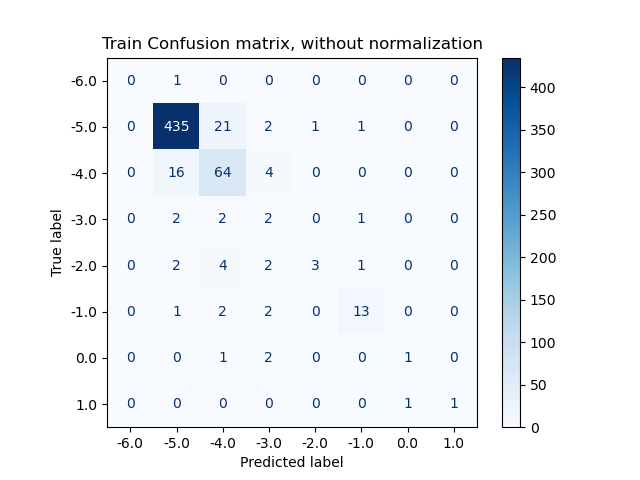

<IPython.core.display.Javascript object>


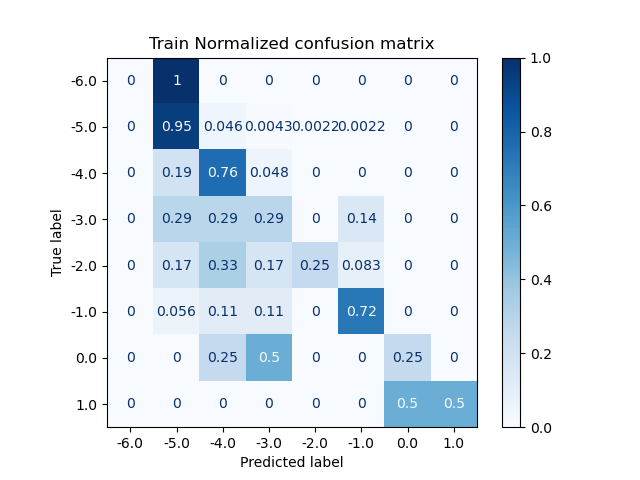

<IPython.core.display.Javascript object>


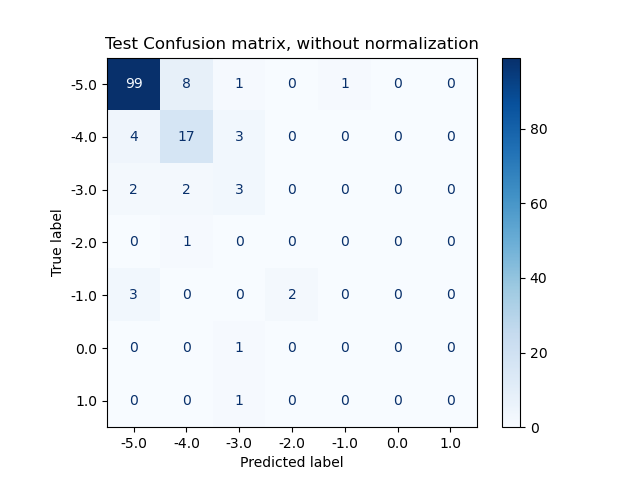

<IPython.core.display.Javascript object>


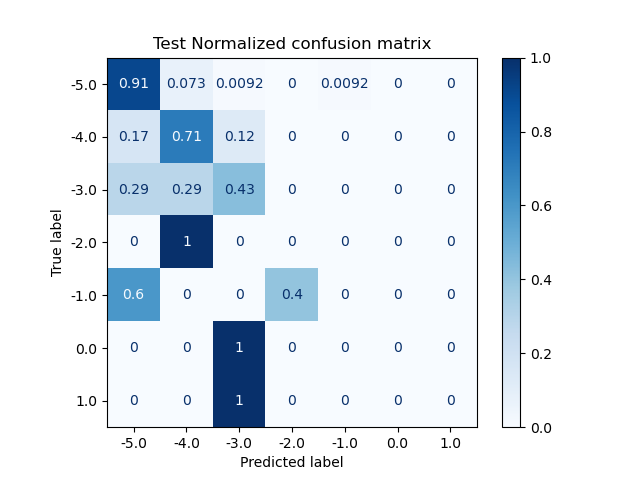

In [293]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    titles_options = [
        (key+ " Confusion matrix, without normalization", None),
        (key+" Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
            np.round(res['y_true']),
            res['y_pred'],
            labels=np.sort(list(set(list(np.round(res['y_true']).unique())).union(set(list(np.round(res['y_pred']).unique()))))),
    #         display_labels=np.sort(list(train_res['y_true'].unique())),
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
        cm = pd.DataFrame(disp.confusion_matrix, index=disp.display_labels, columns=disp.display_labels)
        cm.columns.name='predicted_labels'
        cm.index.name='true_labels'
        cm.to_csv('../notebooks/{}/{}_df_confusion_matrix_{}.csv'.format(exp_name, key, normalize))
        plt.savefig('../notebooks/{}/{}_confusion_matrix_{}.png'.format(exp_name, key, normalize), format='png')
plt.show()

### range result

In [294]:
equal_meaning = True

In [295]:
range_res = pd.read_csv('../notebooks/{}/range_preds.csv'.format(exp_name)).set_index('unique_id').merge(y_range, left_index=True, right_index=True, how='inner')
range_res.columns=['y_pred'] + list(range_res.columns.values)[1:]
range_res['values'] = np.round(range_res['values'])
range_res['updated_values'] = np.nan
range_res['updated_direction'] = np.nan
if equal_meaning:
        range_res.loc[range_res['direction'] == '>=','updated_values'] = range_res['values'] - 1
        range_res.loc[range_res['direction'] == '<=','updated_values'] = range_res['values'] + 1
range_res.loc[range_res['direction'] == '>=','updated_direction'] = '>'
range_res.loc[range_res['direction'] == '<=','updated_direction'] = '<'

range_res.loc[:,'updated_values'].fillna(range_res['values'], inplace=True)
range_res.loc[:,'updated_direction'].fillna(range_res['direction'], inplace=True)

range_res.loc[range_res['updated_direction'] == '>','answer'] = (range_res['y_pred'] > range_res['updated_values'])
range_res.loc[range_res['updated_direction'] == '<','answer'] = (range_res['y_pred'] < range_res['updated_values'])
train_range_res = range_res.loc[set(range_res.index).intersection(set(train.index))]
test_range_res = range_res.loc[set(range_res.index) - set(train.index)]
for key, res in {'train': train_range_res, 'test': test_range_res}.items():
    range_confusion = res.groupby(by=['direction', 'values'])['answer'].agg(['count', 'sum']).replace(True, 1)
    range_confusion['perc'] = range_confusion['sum'] / range_confusion['count']
    range_confusion.columns = ['total', 'in range', 'accuracy']
    range_confusion = pd.DataFrame(range_confusion.stack()).T.swaplevel(i=2, j=0, axis=1)
    range_confusion.index=[key]
    regression_res = pd.concat([regression_res, range_confusion], axis=1)
regression_res_cleaned = pd.DataFrame({})
for col in regression_res.columns:
    if len(regression_res[[col]].columns) > 1:
        regression_res_cleaned[col] = regression_res[[col]].iloc[:,0].fillna(regression_res[[col]].iloc[:,1])
    else:
        regression_res_cleaned[col] = regression_res[[col]]
regression_res = regression_res_cleaned

In [298]:
regression_res

exact RMSE  exact_rounded RMSE (total, -6.0, <) (in range, -6.0, <)  \
train    0.593355            0.586765              NaN                 NaN   
test     0.864756            0.912015             2266                   0   

      (accuracy, -6.0, <) (total, 2.0, >) (in range, 2.0, >)  \
train                 NaN             NaN                NaN   
test                  0.0               3                  0   

      (accuracy, 2.0, >)  
train                NaN  
test                 0.0

In [299]:
regression_res.to_csv('../notebooks/{}/df_regression_results.csv'.format(exp_name))

In [250]:
label

'ciprofloxacin'

## Playing with h2o

In [106]:
filtered_data.head()

tet(C)->seq_id  eptA->seq_id  TEM-206->seq_cov  \
unique_id                                                            
SAMN05771806PATAKI             0.0         76.97               0.0   
SAMN05771805PATAKI             0.0         76.97               0.0   
SAMN05771804PATAKI             0.0         76.97               0.0   
SAMN05771803PATAKI             0.0         76.97               0.0   
SAMN05771802PATAKI             0.0         77.16               0.0   

                    Nocardia_rifampin_resistant_beta-subunit_of_RNA_polymerase_(rpoB2)->seq_id  \
unique_id                                                                                        
SAMN05771806PATAKI                                              75.33                            
SAMN05771805PATAKI                                              75.33                            
SAMN05771804PATAKI                                              75.33                            
SAMN05771803PATAKI                                              75.33                            
SAMN05771802PATAKI                                              75.58                            

                    dfrA16->seq_id  sdiA->seq_id  SHV-134->seq_cov  \
unique_id                                                            
SAMN05771806PATAKI             0.0        100.00               0.0   
SAMN05771805PATAKI             0.0        100.00               0.0   
SAMN05771804PATAKI             0.0        100.00               0.0   
SAMN05771803PATAKI             0.0        100.00               0.0   
SAMN05771802PATAKI             0.0         98.75               0.0   

                    CTX-M-55->seq_cov  AAC(3)-VIa->seq_id  SHV-134->seq_id  \
unique_id                                                                    
SAMN05771806PATAKI                0.0                 0.0              0.0   
SAMN05771805PATAKI                0.0                 0.0              0.0   
SAMN05771804PATAKI                0.0                 0.0              0.0   
SAMN05771803PATAKI                0.0                 0.0              0.0   
SAMN05771802PATAKI                0.0                 0.0              0.0   

                    ...  msrE->seq_id  ugd->seq_cov  \
unique_id           ...                               
SAMN05771806PATAKI  ...           0.0         99.83   
SAMN05771805PATAKI  ...           0.0         99.83   
SAMN05771804PATAKI  ...           0.0         99.83   
SAMN05771803PATAKI  ...           0.0         99.83   
SAMN05771802PATAKI  ...           0.0         99.83   

                    Klebsiella_pneumoniae_KpnF->seq_cov  aadA7->seq_cov  \
unique_id                                                                 
SAMN05771806PATAKI                                 99.7             0.0   
SAMN05771805PATAKI                                 99.7             0.0   
SAMN05771804PATAKI                                 99.7             0.0   
SAMN05771803PATAKI                                 99.7             0.0   
SAMN05771802PATAKI                                 99.7             0.0   

                    aadA12->seq_cov  Escherichia_coli_ampH->seq_cov  \
unique_id                                                             
SAMN05771806PATAKI              0.0                           100.0   
SAMN05771805PATAKI              0.0                           100.0   
SAMN05771804PATAKI              0.0                           100.0   
SAMN05771803PATAKI              0.0                           100.0   
SAMN05771802PATAKI              0.0                           100.0   

                    EreA2->seq_id  QnrA1->seq_cov  baeR->seq_id  ciprofloxacin  
unique_id                                                                       
SAMN05771806PATAKI            0.0             0.0         81.72      -6.058894  
SAMN05771805PATAKI            0.0             0.0         81.72      -6.058894  
SAMN05771804PATAKI            0.0             0.0         81.72      -

In [107]:
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
trainH2o = h2o.import_file('../resources/train_{}_naive.csv'.format(y.name))
testH2o = h2o.import_file('../resources/test_{}_naive.csv'.format(y.name))

# Identify predictors and response
x = features
y = label

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=100, seed=1, max_runtime_secs=86400)
aml.train(x=x, y=y, training_frame=trainH2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# model_id                                                  auc    logloss    mean_per_class_error      rmse       mse
# ---------------------------------------------------  --------  ---------  ----------------------  --------  --------
# StackedEnsemble_AllModels_AutoML_20181212_105540     0.789801   0.551109                0.333174  0.43211   0.186719
# StackedEnsemble_BestOfFamily_AutoML_20181212_105540  0.788425   0.552145                0.323192  0.432625  0.187165
# XGBoost_1_AutoML_20181212_105540                     0.784651   0.55753                 0.325471  0.434949  0.189181
# XGBoost_grid_1_AutoML_20181212_105540_model_4        0.783523   0.557854                0.318819  0.435249  0.189441
# XGBoost_grid_1_AutoML_20181212_105540_model_3        0.783004   0.559613                0.325081  0.435708  0.189841
# XGBoost_2_AutoML_20181212_105540                     0.78136    0.55888                 0.347074  0.435907  0.190015
# XGBoost_3_AutoML_20181212_105540                     0.780847   0.559589                0.330739  0.43613   0.190209
# GBM_5_AutoML_20181212_105540                         0.780837   0.559903                0.340848  0.436191  0.190263
# GBM_2_AutoML_20181212_105540                         0.780036   0.559806                0.339926  0.436415  0.190458
# GBM_1_AutoML_20181212_105540                         0.779827   0.560857                0.335096  0.436616  0.190633
# GBM_3_AutoML_20181212_105540                         0.778669   0.56179                 0.325538  0.437189  0.191134
# XGBoost_grid_1_AutoML_20181212_105540_model_2        0.774411   0.575017                0.322811  0.4427    0.195984
# GBM_4_AutoML_20181212_105540                         0.771426   0.569712                0.33742   0.44107   0.194543
# GBM_grid_1_AutoML_20181212_105540_model_1            0.769752   0.572583                0.344331  0.442452  0.195764
# GBM_grid_1_AutoML_20181212_105540_model_2            0.754366   0.918567                0.355855  0.496638  0.246649
# DRF_1_AutoML_20181212_105540                         0.742892   0.595883                0.355403  0.452774  0.205004
# XRT_1_AutoML_20181212_105540                         0.742091   0.599346                0.356583  0.453117  0.205315
# DeepLearning_grid_1_AutoML_20181212_105540_model_2   0.741795   0.601497                0.368291  0.454904  0.206937
# XGBoost_grid_1_AutoML_20181212_105540_model_1        0.693554   0.620702                0.40588   0.465791  0.216961
# DeepLearning_1_AutoML_20181212_105540                0.69137    0.637954                0.409351  0.47178   0.222576
# DeepLearning_grid_1_AutoML_20181212_105540_model_1   0.690084   0.661794                0.418469  0.476635  0.227181
# GLM_grid_1_AutoML_20181212_105540_model_1            0.682648   0.63852                 0.397234  0.472683  0.223429
#
# [22 rows x 6 columns]

# The leader model is stored here
aml.leader

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ----------------------------------------------------------------------------
H2O_cluster_uptime:         1 min 10 secs
H2O_cluster_timezone:       Asia/Jerusalem
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.0.1
H2O_cluster_version_age:    26 days
H2O_cluster_name:           H2O_from_python_amitdanw_auth_ad_bgu_ac_il_bd4fw5
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.200 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, Infogram, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.12 final
--------------------------  ----------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
23:23:59.206: _train param, Dropping bad and constant columns: [AAC(3)-IIb->seq_cov, dfrA5->seq_cov, AAC(6')-IIc->seq_cov, AAC(3)-IIb->seq_id, dfrA5->seq_id, EreA2->seq_cov, Klebsiella_pneumoniae_KpnH->seq_id, Escherichia_coli_acrA->seq_cov, catII_from_Escherichia_coli_K-12->seq_cov, EreA2->seq_id, Klebsiella_pneumoniae_KpnH->seq_cov, AAC(6')-IIc->seq_id, LAP-2->seq_id, catII_from_Escherichia_coli_K-12->seq_id, LAP-2->seq_cov]

██
23:24:06.254: _train param, Dropping bad and constant columns: [AAC(3)-IIb->seq_cov, dfrA5->seq_cov, AAC(6')-IIc->seq_cov, AAC(3)-IIb->seq_id, dfrA5->seq_id, EreA2->seq_cov, Klebsiella_pneumoniae_KpnH->seq_id, Escherichia_coli_acrA->seq_cov, catII_from_Escherichia_coli_K-12->seq_cov, EreA2->seq_id, Klebsiella_pneumoniae_KpnH->seq_cov, AAC(6')-IIc->seq_id

In [ ]:
preds = aml.predict(testH2o)

## Playing with Amoxicillin - Clavulanic acid as regression

In [223]:
X = filtered_data[features]
y = filtered_data[best_label+'_filtered']

In [226]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [228]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0).fit(X.iloc[train_index], y.iloc[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    print("rounded: ", rounded_predictions)
    print("actual: ", actuals.T[0])
    print(mean_squared_error(actuals, predictions))
    print(confusion_matrix([str(x) for x in actuals.T[0]], [str(x) for x in rounded_predictions]))
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)

XGBoostError: [11:31:40] /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/gbm/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a393b) [0x7f992193f93b]
  [bt] (1) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a39cc) [0x7f992193f9cc]
  [bt] (2) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xa5) [0x7f992193fa85]
  [bt] (3) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x309) [0x7f9921956039]
  [bt] (4) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1e67fd) [0x7f99219827fd]
  [bt] (5) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1d5787) [0x7f9921971787]
  [bt] (6) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(XGBoosterUpdateOneIter+0x4c) [0x7f9921855abc]
  [bt] (7) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f999bbf1a4a]
  [bt] (8) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f999bbf0fea]



In [291]:
print(mean_squared_error(tot_actuals, tot_predictions))

0.7742366563759465


<IPython.core.display.Javascript object>


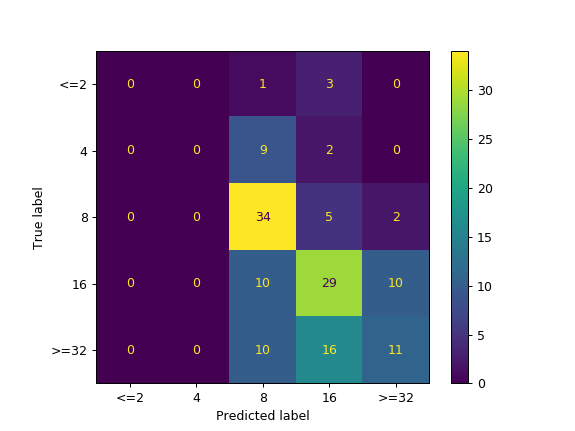

In [292]:
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

### run Parameter Opt

In [319]:
param_grid = {
    'max_depth':[3, 4, 6, 8, 10], 
    'n_estimators': [20, 50, 100, 200],
    'eta': uniform(loc=0, scale=1),
    'gamma': uniform(loc=0, scale=100),
    'min_child_weight': uniform(loc=0, scale=10),
    ''
}

In [320]:
xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0)

In [321]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [322]:
clf = RandomizedSearchCV(xgb_model, param_distributions=param_grid, random_state=rng, cv = kf)

In [323]:
search = clf.fit(X, y)
search.best_params_
search.best_score_

[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.2719582886878314

[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

<IPython.core.display.Javascript object>


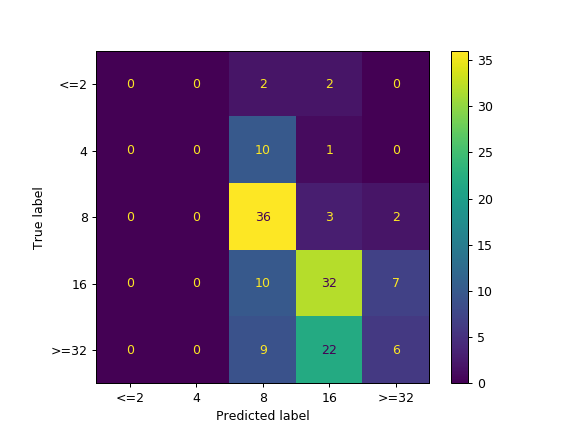

In [324]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, **search.best_params_).fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)
    
print(mean_squared_error(tot_actuals, tot_predictions))
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

In [318]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)